In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 460)
(884582, 3)
validation
(154411, 460)
(154411, 3)
test
(115112, 460)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 2048)              944128    


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 3731715 (14.24 MB)


Trainable params: 3731715 (14.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:04 - loss: 1.2396 - STD: 0.1328 - MAE: 0.4611

2/9 [=====>........................] - ETA: 56s - loss: 1.1501 - STD: 0.1075 - MAE: 0.4468 

3/9 [=========>....................] - ETA: 25s - loss: 1.1382 - STD: 0.1199 - MAE: 0.4392

4/9 [============>.................] - ETA: 14s - loss: 1.1376 - STD: 0.1297 - MAE: 0.4348

5/9 [===============>..............] - ETA: 9s - loss: 1.1350 - STD: 0.1349 - MAE: 0.4321 

6/9 [===================>..........] - ETA: 5s - loss: 1.1298 - STD: 0.1357 - MAE: 0.4307

7/9 [======================>.......] - ETA: 3s - loss: 1.1233 - STD: 0.1324 - MAE: 0.4304

8/9 [=========================>....] - ETA: 1s - loss: 1.1170 - STD: 0.1256 - MAE: 0.4307

9/9 [==============================] - ETA: 0s - loss: 1.1124 - STD: 0.1167 - MAE: 0.4315

9/9 [==============================] - 21s 2s/step - loss: 1.1124 - STD: 0.1167 - MAE: 0.4315 - val_loss: 1.0866 - val_STD: 0.0262 - val_MAE: 0.4411


Epoch 2/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0865 - STD: 0.0263 - MAE: 0.4410

2/9 [=====>........................] - ETA: 2s - loss: 1.0898 - STD: 0.0263 - MAE: 0.4417

3/9 [=========>....................] - ETA: 1s - loss: 1.0905 - STD: 0.0280 - MAE: 0.4418

4/9 [============>.................] - ETA: 1s - loss: 1.0893 - STD: 0.0302 - MAE: 0.4414

5/9 [===============>..............] - ETA: 1s - loss: 1.0871 - STD: 0.0335 - MAE: 0.4407

6/9 [===================>..........] - ETA: 0s - loss: 1.0847 - STD: 0.0381 - MAE: 0.4398

7/9 [======================>.......] - ETA: 0s - loss: 1.0831 - STD: 0.0436 - MAE: 0.4388

8/9 [=========================>....] - ETA: 0s - loss: 1.0819 - STD: 0.0495 - MAE: 0.4378

9/9 [==============================] - ETA: 0s - loss: 1.0813 - STD: 0.0553 - MAE: 0.4368

9/9 [==============================] - 3s 353ms/step - loss: 1.0813 - STD: 0.0553 - MAE: 0.4368 - val_loss: 1.0784 - val_STD: 0.1075 - val_MAE: 0.4281


Epoch 3/10000


1/9 [==>...........................] - ETA: 2s - loss: 1.0782 - STD: 0.1076 - MAE: 0.4280

2/9 [=====>........................] - ETA: 2s - loss: 1.0783 - STD: 0.1085 - MAE: 0.4278

3/9 [=========>....................] - ETA: 1s - loss: 1.0778 - STD: 0.1078 - MAE: 0.4279

4/9 [============>.................] - ETA: 1s - loss: 1.0768 - STD: 0.1055 - MAE: 0.4281

5/9 [===============>..............] - ETA: 1s - loss: 1.0751 - STD: 0.1019 - MAE: 0.4285

6/9 [===================>..........] - ETA: 0s - loss: 1.0737 - STD: 0.0977 - MAE: 0.4290

7/9 [======================>.......] - ETA: 0s - loss: 1.0724 - STD: 0.0931 - MAE: 0.4295

8/9 [=========================>....] - ETA: 0s - loss: 1.0711 - STD: 0.0888 - MAE: 0.4299

9/9 [==============================] - ETA: 0s - loss: 1.0697 - STD: 0.0849 - MAE: 0.4302

9/9 [==============================] - 3s 359ms/step - loss: 1.0697 - STD: 0.0849 - MAE: 0.4302 - val_loss: 1.0548 - val_STD: 0.0510 - val_MAE: 0.4318


Epoch 4/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0548 - STD: 0.0526 - MAE: 0.4316

2/9 [=====>........................] - ETA: 2s - loss: 1.0506 - STD: 0.0532 - MAE: 0.4305

3/9 [=========>....................] - ETA: 1s - loss: 1.0460 - STD: 0.0549 - MAE: 0.4291

4/9 [============>.................] - ETA: 1s - loss: 1.0400 - STD: 0.0578 - MAE: 0.4273

5/9 [===============>..............] - ETA: 1s - loss: 1.0331 - STD: 0.0619 - MAE: 0.4250

6/9 [===================>..........] - ETA: 0s - loss: 1.0253 - STD: 0.0667 - MAE: 0.4222

7/9 [======================>.......] - ETA: 0s - loss: 1.0161 - STD: 0.0719 - MAE: 0.4190

8/9 [=========================>....] - ETA: 0s - loss: 1.0056 - STD: 0.0782 - MAE: 0.4151

9/9 [==============================] - ETA: 0s - loss: 0.9960 - STD: 0.0852 - MAE: 0.4108

9/9 [==============================] - 3s 368ms/step - loss: 0.9960 - STD: 0.0852 - MAE: 0.4108 - val_loss: 0.8991 - val_STD: 0.1554 - val_MAE: 0.3720


Epoch 5/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8748 - STD: 0.1590 - MAE: 0.3643

2/9 [=====>........................] - ETA: 2s - loss: 0.8640 - STD: 0.1752 - MAE: 0.3566

3/9 [=========>....................] - ETA: 1s - loss: 0.8522 - STD: 0.1828 - MAE: 0.3517

4/9 [============>.................] - ETA: 1s - loss: 0.8411 - STD: 0.1934 - MAE: 0.3455

5/9 [===============>..............] - ETA: 1s - loss: 0.8327 - STD: 0.2021 - MAE: 0.3402

6/9 [===================>..........] - ETA: 0s - loss: 0.8254 - STD: 0.2084 - MAE: 0.3364

7/9 [======================>.......] - ETA: 0s - loss: 0.8195 - STD: 0.2163 - MAE: 0.3319

8/9 [=========================>....] - ETA: 0s - loss: 0.8131 - STD: 0.2217 - MAE: 0.3283

9/9 [==============================] - ETA: 0s - loss: 0.8092 - STD: 0.2255 - MAE: 0.3260

9/9 [==============================] - 3s 354ms/step - loss: 0.8092 - STD: 0.2255 - MAE: 0.3260 - val_loss: 0.8025 - val_STD: 0.2582 - val_MAE: 0.3103


Epoch 6/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.7642 - STD: 0.2715 - MAE: 0.2959

2/9 [=====>........................] - ETA: 2s - loss: 0.7596 - STD: 0.2701 - MAE: 0.2959

3/9 [=========>....................] - ETA: 1s - loss: 0.7603 - STD: 0.2650 - MAE: 0.2989

4/9 [============>.................] - ETA: 1s - loss: 0.7557 - STD: 0.2656 - MAE: 0.2977

5/9 [===============>..............] - ETA: 1s - loss: 0.7513 - STD: 0.2659 - MAE: 0.2968

6/9 [===================>..........] - ETA: 0s - loss: 0.7492 - STD: 0.2631 - MAE: 0.2978

7/9 [======================>.......] - ETA: 0s - loss: 0.7450 - STD: 0.2628 - MAE: 0.2973

8/9 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2633 - MAE: 0.2965

9/9 [==============================] - ETA: 0s - loss: 0.7399 - STD: 0.2624 - MAE: 0.2966

9/9 [==============================] - 3s 356ms/step - loss: 0.7399 - STD: 0.2624 - MAE: 0.2966 - val_loss: 0.7444 - val_STD: 0.2600 - val_MAE: 0.3002


Epoch 7/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.7112 - STD: 0.2670 - MAE: 0.2890

2/9 [=====>........................] - ETA: 2s - loss: 0.7109 - STD: 0.2732 - MAE: 0.2856

3/9 [=========>....................] - ETA: 1s - loss: 0.7096 - STD: 0.2729 - MAE: 0.2857

4/9 [============>.................] - ETA: 1s - loss: 0.7067 - STD: 0.2744 - MAE: 0.2843

5/9 [===============>..............] - ETA: 1s - loss: 0.7053 - STD: 0.2770 - MAE: 0.2827

6/9 [===================>..........] - ETA: 0s - loss: 0.7036 - STD: 0.2770 - MAE: 0.2824

7/9 [======================>.......] - ETA: 0s - loss: 0.7015 - STD: 0.2773 - MAE: 0.2819

8/9 [=========================>....] - ETA: 0s - loss: 0.6997 - STD: 0.2781 - MAE: 0.2811

9/9 [==============================] - ETA: 0s - loss: 0.6985 - STD: 0.2773 - MAE: 0.2813

9/9 [==============================] - 3s 362ms/step - loss: 0.6985 - STD: 0.2773 - MAE: 0.2813 - val_loss: 0.7043 - val_STD: 0.2763 - val_MAE: 0.2830


Epoch 8/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6808 - STD: 0.2811 - MAE: 0.2755

2/9 [=====>........................] - ETA: 2s - loss: 0.6769 - STD: 0.2818 - MAE: 0.2743

3/9 [=========>....................] - ETA: 1s - loss: 0.6772 - STD: 0.2809 - MAE: 0.2749

4/9 [============>.................] - ETA: 1s - loss: 0.6764 - STD: 0.2836 - MAE: 0.2733

5/9 [===============>..............] - ETA: 1s - loss: 0.6741 - STD: 0.2848 - MAE: 0.2721

6/9 [===================>..........] - ETA: 0s - loss: 0.6723 - STD: 0.2853 - MAE: 0.2715

7/9 [======================>.......] - ETA: 0s - loss: 0.6711 - STD: 0.2868 - MAE: 0.2704

8/9 [=========================>....] - ETA: 0s - loss: 0.6693 - STD: 0.2867 - MAE: 0.2702

9/9 [==============================] - ETA: 0s - loss: 0.6678 - STD: 0.2870 - MAE: 0.2697

9/9 [==============================] - 3s 352ms/step - loss: 0.6678 - STD: 0.2870 - MAE: 0.2697 - val_loss: 0.6693 - val_STD: 0.2930 - val_MAE: 0.2674


Epoch 9/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6554 - STD: 0.2918 - MAE: 0.2646

2/9 [=====>........................] - ETA: 2s - loss: 0.6539 - STD: 0.2904 - MAE: 0.2653

3/9 [=========>....................] - ETA: 1s - loss: 0.6529 - STD: 0.2933 - MAE: 0.2634

4/9 [============>.................] - ETA: 1s - loss: 0.6507 - STD: 0.2936 - MAE: 0.2628

5/9 [===============>..............] - ETA: 1s - loss: 0.6483 - STD: 0.2944 - MAE: 0.2618

6/9 [===================>..........] - ETA: 0s - loss: 0.6467 - STD: 0.2950 - MAE: 0.2611

7/9 [======================>.......] - ETA: 0s - loss: 0.6454 - STD: 0.2951 - MAE: 0.2608

8/9 [=========================>....] - ETA: 0s - loss: 0.6443 - STD: 0.2956 - MAE: 0.2602

9/9 [==============================] - ETA: 0s - loss: 0.6421 - STD: 0.2959 - MAE: 0.2596

9/9 [==============================] - 3s 361ms/step - loss: 0.6421 - STD: 0.2959 - MAE: 0.2596 - val_loss: 0.6407 - val_STD: 0.3060 - val_MAE: 0.2535


Epoch 10/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.6282 - STD: 0.3042 - MAE: 0.2515

2/9 [=====>........................] - ETA: 2s - loss: 0.6288 - STD: 0.3033 - MAE: 0.2523

3/9 [=========>....................] - ETA: 1s - loss: 0.6307 - STD: 0.3054 - MAE: 0.2511

4/9 [============>.................] - ETA: 1s - loss: 0.6387 - STD: 0.3037 - MAE: 0.2541

5/9 [===============>..............] - ETA: 1s - loss: 0.6437 - STD: 0.3057 - MAE: 0.2536

6/9 [===================>..........] - ETA: 0s - loss: 0.6387 - STD: 0.3051 - MAE: 0.2530

7/9 [======================>.......] - ETA: 0s - loss: 0.6381 - STD: 0.3046 - MAE: 0.2534

8/9 [=========================>....] - ETA: 0s - loss: 0.6384 - STD: 0.3056 - MAE: 0.2526

9/9 [==============================] - ETA: 0s - loss: 0.6350 - STD: 0.3060 - MAE: 0.2517

9/9 [==============================] - 3s 358ms/step - loss: 0.6350 - STD: 0.3060 - MAE: 0.2517 - val_loss: 0.6697 - val_STD: 0.3116 - val_MAE: 0.2566


Epoch 11/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.6388 - STD: 0.3055 - MAE: 0.2544

2/9 [=====>........................] - ETA: 2s - loss: 0.6263 - STD: 0.3090 - MAE: 0.2487

3/9 [=========>....................] - ETA: 1s - loss: 0.6210 - STD: 0.3101 - MAE: 0.2466

4/9 [============>.................] - ETA: 1s - loss: 0.6211 - STD: 0.3092 - MAE: 0.2474

5/9 [===============>..............] - ETA: 1s - loss: 0.6171 - STD: 0.3092 - MAE: 0.2466

6/9 [===================>..........] - ETA: 0s - loss: 0.6171 - STD: 0.3101 - MAE: 0.2458

7/9 [======================>.......] - ETA: 0s - loss: 0.6140 - STD: 0.3104 - MAE: 0.2451

8/9 [=========================>....] - ETA: 0s - loss: 0.6128 - STD: 0.3106 - MAE: 0.2448

9/9 [==============================] - ETA: 0s - loss: 0.6117 - STD: 0.3112 - MAE: 0.2440

9/9 [==============================] - 3s 362ms/step - loss: 0.6117 - STD: 0.3112 - MAE: 0.2440 - val_loss: 0.5968 - val_STD: 0.3169 - val_MAE: 0.2377


Epoch 12/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.5962 - STD: 0.3167 - MAE: 0.2368

2/9 [=====>........................] - ETA: 2s - loss: 0.5996 - STD: 0.3153 - MAE: 0.2391

3/9 [=========>....................] - ETA: 1s - loss: 0.5972 - STD: 0.3147 - MAE: 0.2388

4/9 [============>.................] - ETA: 1s - loss: 0.5961 - STD: 0.3150 - MAE: 0.2382

5/9 [===============>..............] - ETA: 1s - loss: 0.5935 - STD: 0.3153 - MAE: 0.2376

6/9 [===================>..........] - ETA: 0s - loss: 0.5920 - STD: 0.3158 - MAE: 0.2370

7/9 [======================>.......] - ETA: 0s - loss: 0.5911 - STD: 0.3165 - MAE: 0.2363

8/9 [=========================>....] - ETA: 0s - loss: 0.5895 - STD: 0.3171 - MAE: 0.2356

9/9 [==============================] - ETA: 0s - loss: 0.5888 - STD: 0.3177 - MAE: 0.2352

9/9 [==============================] - 3s 370ms/step - loss: 0.5888 - STD: 0.3177 - MAE: 0.2352 - val_loss: 0.5750 - val_STD: 0.3184 - val_MAE: 0.2322


Epoch 13/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5819 - STD: 0.3194 - MAE: 0.2316

2/9 [=====>........................] - ETA: 1s - loss: 0.5788 - STD: 0.3191 - MAE: 0.2315

3/9 [=========>....................] - ETA: 1s - loss: 0.5776 - STD: 0.3201 - MAE: 0.2310

4/9 [============>.................] - ETA: 1s - loss: 0.5755 - STD: 0.3208 - MAE: 0.2300

5/9 [===============>..............] - ETA: 1s - loss: 0.5740 - STD: 0.3218 - MAE: 0.2291

6/9 [===================>..........] - ETA: 0s - loss: 0.5736 - STD: 0.3229 - MAE: 0.2284

7/9 [======================>.......] - ETA: 0s - loss: 0.5729 - STD: 0.3233 - MAE: 0.2279

8/9 [=========================>....] - ETA: 0s - loss: 0.5718 - STD: 0.3236 - MAE: 0.2275

9/9 [==============================] - ETA: 0s - loss: 0.5707 - STD: 0.3239 - MAE: 0.2271

9/9 [==============================] - 3s 360ms/step - loss: 0.5707 - STD: 0.3239 - MAE: 0.2271 - val_loss: 0.5544 - val_STD: 0.3225 - val_MAE: 0.2251


Epoch 14/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5712 - STD: 0.3244 - MAE: 0.2264

2/9 [=====>........................] - ETA: 2s - loss: 0.5658 - STD: 0.3276 - MAE: 0.2237

3/9 [=========>....................] - ETA: 1s - loss: 0.5639 - STD: 0.3287 - MAE: 0.2225

4/9 [============>.................] - ETA: 1s - loss: 0.5613 - STD: 0.3291 - MAE: 0.2217

5/9 [===============>..............] - ETA: 1s - loss: 0.5595 - STD: 0.3295 - MAE: 0.2211

6/9 [===================>..........] - ETA: 0s - loss: 0.5589 - STD: 0.3293 - MAE: 0.2210

7/9 [======================>.......] - ETA: 0s - loss: 0.5581 - STD: 0.3298 - MAE: 0.2206

8/9 [=========================>....] - ETA: 0s - loss: 0.5568 - STD: 0.3303 - MAE: 0.2199

9/9 [==============================] - ETA: 0s - loss: 0.5550 - STD: 0.3308 - MAE: 0.2192

9/9 [==============================] - 3s 357ms/step - loss: 0.5550 - STD: 0.3308 - MAE: 0.2192 - val_loss: 0.5634 - val_STD: 0.3359 - val_MAE: 0.2194


Epoch 15/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5509 - STD: 0.3364 - MAE: 0.2149

2/9 [=====>........................] - ETA: 2s - loss: 0.5475 - STD: 0.3346 - MAE: 0.2152

3/9 [=========>....................] - ETA: 1s - loss: 0.5463 - STD: 0.3347 - MAE: 0.2149

4/9 [============>.................] - ETA: 1s - loss: 0.5443 - STD: 0.3349 - MAE: 0.2142

5/9 [===============>..............] - ETA: 1s - loss: 0.5426 - STD: 0.3356 - MAE: 0.2134

6/9 [===================>..........] - ETA: 0s - loss: 0.5415 - STD: 0.3364 - MAE: 0.2127

7/9 [======================>.......] - ETA: 0s - loss: 0.5410 - STD: 0.3365 - MAE: 0.2125

8/9 [=========================>....] - ETA: 0s - loss: 0.5404 - STD: 0.3370 - MAE: 0.2121

9/9 [==============================] - ETA: 0s - loss: 0.5405 - STD: 0.3368 - MAE: 0.2121

9/9 [==============================] - 3s 347ms/step - loss: 0.5405 - STD: 0.3368 - MAE: 0.2121 - val_loss: 0.5564 - val_STD: 0.3394 - val_MAE: 0.2157


Epoch 16/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.5334 - STD: 0.3416 - MAE: 0.2075

2/9 [=====>........................] - ETA: 2s - loss: 0.5344 - STD: 0.3404 - MAE: 0.2082

3/9 [=========>....................] - ETA: 1s - loss: 0.5326 - STD: 0.3412 - MAE: 0.2075

4/9 [============>.................] - ETA: 1s - loss: 0.5310 - STD: 0.3408 - MAE: 0.2073

5/9 [===============>..............] - ETA: 1s - loss: 0.5292 - STD: 0.3411 - MAE: 0.2068

6/9 [===================>..........] - ETA: 0s - loss: 0.5278 - STD: 0.3413 - MAE: 0.2064

7/9 [======================>.......] - ETA: 0s - loss: 0.5268 - STD: 0.3418 - MAE: 0.2058

8/9 [=========================>....] - ETA: 0s - loss: 0.5260 - STD: 0.3419 - MAE: 0.2055

9/9 [==============================] - ETA: 0s - loss: 0.5246 - STD: 0.3422 - MAE: 0.2050

9/9 [==============================] - 3s 355ms/step - loss: 0.5246 - STD: 0.3422 - MAE: 0.2050 - val_loss: 0.5026 - val_STD: 0.3378 - val_MAE: 0.2051


Epoch 17/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.5197 - STD: 0.3425 - MAE: 0.2035

2/9 [=====>........................] - ETA: 2s - loss: 0.5172 - STD: 0.3456 - MAE: 0.2013

3/9 [=========>....................] - ETA: 1s - loss: 0.5191 - STD: 0.3447 - MAE: 0.2022

4/9 [============>.................] - ETA: 1s - loss: 0.5254 - STD: 0.3461 - MAE: 0.2024

5/9 [===============>..............] - ETA: 1s - loss: 0.5376 - STD: 0.3438 - MAE: 0.2064

6/9 [===================>..........] - ETA: 0s - loss: 0.5374 - STD: 0.3446 - MAE: 0.2058

7/9 [======================>.......] - ETA: 0s - loss: 0.5327 - STD: 0.3452 - MAE: 0.2044

8/9 [=========================>....] - ETA: 0s - loss: 0.5305 - STD: 0.3456 - MAE: 0.2037

9/9 [==============================] - ETA: 0s - loss: 0.5291 - STD: 0.3462 - MAE: 0.2030

9/9 [==============================] - 3s 362ms/step - loss: 0.5291 - STD: 0.3462 - MAE: 0.2030 - val_loss: 0.5022 - val_STD: 0.3397 - val_MAE: 0.2042


Epoch 18/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5009 - STD: 0.3445 - MAE: 0.1984

2/9 [=====>........................] - ETA: 1s - loss: 0.5019 - STD: 0.3449 - MAE: 0.1984

3/9 [=========>....................] - ETA: 1s - loss: 0.5052 - STD: 0.3477 - MAE: 0.1971

4/9 [============>.................] - ETA: 1s - loss: 0.5027 - STD: 0.3475 - MAE: 0.1967

5/9 [===============>..............] - ETA: 1s - loss: 0.5017 - STD: 0.3469 - MAE: 0.1969

6/9 [===================>..........] - ETA: 0s - loss: 0.5013 - STD: 0.3475 - MAE: 0.1964

7/9 [======================>.......] - ETA: 0s - loss: 0.5007 - STD: 0.3477 - MAE: 0.1962

8/9 [=========================>....] - ETA: 0s - loss: 0.4992 - STD: 0.3480 - MAE: 0.1957

9/9 [==============================] - ETA: 0s - loss: 0.4983 - STD: 0.3483 - MAE: 0.1953

9/9 [==============================] - 3s 355ms/step - loss: 0.4983 - STD: 0.3483 - MAE: 0.1953 - val_loss: 0.4800 - val_STD: 0.3448 - val_MAE: 0.1959


Epoch 19/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4929 - STD: 0.3484 - MAE: 0.1941

2/9 [=====>........................] - ETA: 1s - loss: 0.4884 - STD: 0.3524 - MAE: 0.1904

3/9 [=========>....................] - ETA: 1s - loss: 0.4857 - STD: 0.3530 - MAE: 0.1895

4/9 [============>.................] - ETA: 1s - loss: 0.4850 - STD: 0.3526 - MAE: 0.1896

5/9 [===============>..............] - ETA: 1s - loss: 0.4848 - STD: 0.3542 - MAE: 0.1885

6/9 [===================>..........] - ETA: 0s - loss: 0.4843 - STD: 0.3543 - MAE: 0.1883

7/9 [======================>.......] - ETA: 0s - loss: 0.4825 - STD: 0.3547 - MAE: 0.1876

8/9 [=========================>....] - ETA: 0s - loss: 0.4817 - STD: 0.3552 - MAE: 0.1871

9/9 [==============================] - ETA: 0s - loss: 0.4805 - STD: 0.3554 - MAE: 0.1868

9/9 [==============================] - 3s 358ms/step - loss: 0.4805 - STD: 0.3554 - MAE: 0.1868 - val_loss: 0.5019 - val_STD: 0.3560 - val_MAE: 0.1936


Epoch 20/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4803 - STD: 0.3598 - MAE: 0.1836

2/9 [=====>........................] - ETA: 1s - loss: 0.4756 - STD: 0.3574 - MAE: 0.1845

3/9 [=========>....................] - ETA: 1s - loss: 0.4745 - STD: 0.3595 - MAE: 0.1830

4/9 [============>.................] - ETA: 1s - loss: 0.4721 - STD: 0.3586 - MAE: 0.1832

5/9 [===============>..............] - ETA: 1s - loss: 0.4700 - STD: 0.3592 - MAE: 0.1824

6/9 [===================>..........] - ETA: 0s - loss: 0.4691 - STD: 0.3597 - MAE: 0.1819

7/9 [======================>.......] - ETA: 0s - loss: 0.4684 - STD: 0.3594 - MAE: 0.1820

8/9 [=========================>....] - ETA: 0s - loss: 0.4677 - STD: 0.3601 - MAE: 0.1814

9/9 [==============================] - ETA: 0s - loss: 0.4674 - STD: 0.3599 - MAE: 0.1815

9/9 [==============================] - 3s 349ms/step - loss: 0.4674 - STD: 0.3599 - MAE: 0.1815 - val_loss: 0.5010 - val_STD: 0.3612 - val_MAE: 0.1900


Epoch 21/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4678 - STD: 0.3645 - MAE: 0.1784

2/9 [=====>........................] - ETA: 2s - loss: 0.4679 - STD: 0.3616 - MAE: 0.1806

3/9 [=========>....................] - ETA: 1s - loss: 0.4668 - STD: 0.3637 - MAE: 0.1790

4/9 [============>.................] - ETA: 1s - loss: 0.4633 - STD: 0.3627 - MAE: 0.1791

5/9 [===============>..............] - ETA: 1s - loss: 0.4610 - STD: 0.3631 - MAE: 0.1783

6/9 [===================>..........] - ETA: 0s - loss: 0.4587 - STD: 0.3636 - MAE: 0.1776

7/9 [======================>.......] - ETA: 0s - loss: 0.4581 - STD: 0.3632 - MAE: 0.1777

8/9 [=========================>....] - ETA: 0s - loss: 0.4582 - STD: 0.3637 - MAE: 0.1774

9/9 [==============================] - ETA: 0s - loss: 0.4596 - STD: 0.3633 - MAE: 0.1780

9/9 [==============================] - 3s 349ms/step - loss: 0.4596 - STD: 0.3633 - MAE: 0.1780 - val_loss: 0.5092 - val_STD: 0.3641 - val_MAE: 0.1897


Epoch 22/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4668 - STD: 0.3658 - MAE: 0.1776

2/9 [=====>........................] - ETA: 2s - loss: 0.4676 - STD: 0.3631 - MAE: 0.1799

3/9 [=========>....................] - ETA: 1s - loss: 0.4644 - STD: 0.3652 - MAE: 0.1777

4/9 [============>.................] - ETA: 1s - loss: 0.4599 - STD: 0.3646 - MAE: 0.1773

5/9 [===============>..............] - ETA: 1s - loss: 0.4567 - STD: 0.3650 - MAE: 0.1763

6/9 [===================>..........] - ETA: 0s - loss: 0.4546 - STD: 0.3658 - MAE: 0.1753

7/9 [======================>.......] - ETA: 0s - loss: 0.4542 - STD: 0.3652 - MAE: 0.1757

8/9 [=========================>....] - ETA: 0s - loss: 0.4534 - STD: 0.3656 - MAE: 0.1753

9/9 [==============================] - ETA: 0s - loss: 0.4520 - STD: 0.3656 - MAE: 0.1750

9/9 [==============================] - 3s 359ms/step - loss: 0.4520 - STD: 0.3656 - MAE: 0.1750 - val_loss: 0.4667 - val_STD: 0.3662 - val_MAE: 0.1800


Epoch 23/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4415 - STD: 0.3652 - MAE: 0.1731

2/9 [=====>........................] - ETA: 2s - loss: 0.4390 - STD: 0.3661 - MAE: 0.1722

3/9 [=========>....................] - ETA: 1s - loss: 0.4376 - STD: 0.3665 - MAE: 0.1716

4/9 [============>.................] - ETA: 1s - loss: 0.4379 - STD: 0.3669 - MAE: 0.1713

5/9 [===============>..............] - ETA: 1s - loss: 0.4396 - STD: 0.3665 - MAE: 0.1720

6/9 [===================>..........] - ETA: 0s - loss: 0.4397 - STD: 0.3675 - MAE: 0.1713

7/9 [======================>.......] - ETA: 0s - loss: 0.4389 - STD: 0.3673 - MAE: 0.1713

8/9 [=========================>....] - ETA: 0s - loss: 0.4390 - STD: 0.3677 - MAE: 0.1711

9/9 [==============================] - ETA: 0s - loss: 0.4387 - STD: 0.3679 - MAE: 0.1708

9/9 [==============================] - 3s 355ms/step - loss: 0.4387 - STD: 0.3679 - MAE: 0.1708 - val_loss: 0.4592 - val_STD: 0.3709 - val_MAE: 0.1750


Epoch 24/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4309 - STD: 0.3704 - MAE: 0.1674

2/9 [=====>........................] - ETA: 2s - loss: 0.4313 - STD: 0.3702 - MAE: 0.1677

3/9 [=========>....................] - ETA: 1s - loss: 0.4304 - STD: 0.3703 - MAE: 0.1675

4/9 [============>.................] - ETA: 1s - loss: 0.4308 - STD: 0.3705 - MAE: 0.1674

5/9 [===============>..............] - ETA: 1s - loss: 0.4314 - STD: 0.3700 - MAE: 0.1679

6/9 [===================>..........] - ETA: 0s - loss: 0.4318 - STD: 0.3706 - MAE: 0.1676

7/9 [======================>.......] - ETA: 0s - loss: 0.4337 - STD: 0.3700 - MAE: 0.1684

8/9 [=========================>....] - ETA: 0s - loss: 0.4353 - STD: 0.3709 - MAE: 0.1680

9/9 [==============================] - ETA: 0s - loss: 0.4349 - STD: 0.3706 - MAE: 0.1682

9/9 [==============================] - 3s 357ms/step - loss: 0.4349 - STD: 0.3706 - MAE: 0.1682 - val_loss: 0.4527 - val_STD: 0.3729 - val_MAE: 0.1721


Epoch 25/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4253 - STD: 0.3730 - MAE: 0.1646

2/9 [=====>........................] - ETA: 2s - loss: 0.4261 - STD: 0.3737 - MAE: 0.1643

3/9 [=========>....................] - ETA: 1s - loss: 0.4266 - STD: 0.3721 - MAE: 0.1656

4/9 [============>.................] - ETA: 1s - loss: 0.4269 - STD: 0.3729 - MAE: 0.1650

5/9 [===============>..............] - ETA: 1s - loss: 0.4269 - STD: 0.3726 - MAE: 0.1652

6/9 [===================>..........] - ETA: 0s - loss: 0.4272 - STD: 0.3723 - MAE: 0.1655

7/9 [======================>.......] - ETA: 0s - loss: 0.4264 - STD: 0.3726 - MAE: 0.1651

8/9 [=========================>....] - ETA: 0s - loss: 0.4248 - STD: 0.3727 - MAE: 0.1648

9/9 [==============================] - ETA: 0s - loss: 0.4248 - STD: 0.3725 - MAE: 0.1649

9/9 [==============================] - 3s 358ms/step - loss: 0.4248 - STD: 0.3725 - MAE: 0.1649 - val_loss: 0.4139 - val_STD: 0.3754 - val_MAE: 0.1615


Epoch 26/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4306 - STD: 0.3736 - MAE: 0.1653

2/9 [=====>........................] - ETA: 2s - loss: 0.4268 - STD: 0.3736 - MAE: 0.1645

3/9 [=========>....................] - ETA: 1s - loss: 0.4276 - STD: 0.3722 - MAE: 0.1657

4/9 [============>.................] - ETA: 1s - loss: 0.4283 - STD: 0.3741 - MAE: 0.1644

5/9 [===============>..............] - ETA: 1s - loss: 0.4265 - STD: 0.3734 - MAE: 0.1646

6/9 [===================>..........] - ETA: 0s - loss: 0.4245 - STD: 0.3736 - MAE: 0.1640

7/9 [======================>.......] - ETA: 0s - loss: 0.4234 - STD: 0.3741 - MAE: 0.1634

8/9 [=========================>....] - ETA: 0s - loss: 0.4224 - STD: 0.3740 - MAE: 0.1633

9/9 [==============================] - ETA: 0s - loss: 0.4219 - STD: 0.3744 - MAE: 0.1629

9/9 [==============================] - 3s 352ms/step - loss: 0.4219 - STD: 0.3744 - MAE: 0.1629 - val_loss: 0.4152 - val_STD: 0.3762 - val_MAE: 0.1613


Epoch 27/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4318 - STD: 0.3727 - MAE: 0.1656

2/9 [=====>........................] - ETA: 2s - loss: 0.4287 - STD: 0.3742 - MAE: 0.1640

3/9 [=========>....................] - ETA: 1s - loss: 0.4262 - STD: 0.3735 - MAE: 0.1641

4/9 [============>.................] - ETA: 1s - loss: 0.4227 - STD: 0.3749 - MAE: 0.1625

5/9 [===============>..............] - ETA: 1s - loss: 0.4207 - STD: 0.3746 - MAE: 0.1624

6/9 [===================>..........] - ETA: 0s - loss: 0.4195 - STD: 0.3747 - MAE: 0.1620

7/9 [======================>.......] - ETA: 0s - loss: 0.4181 - STD: 0.3752 - MAE: 0.1614

8/9 [=========================>....] - ETA: 0s - loss: 0.4184 - STD: 0.3748 - MAE: 0.1618

9/9 [==============================] - ETA: 0s - loss: 0.4191 - STD: 0.3757 - MAE: 0.1613

9/9 [==============================] - 3s 347ms/step - loss: 0.4191 - STD: 0.3757 - MAE: 0.1613 - val_loss: 0.4282 - val_STD: 0.3782 - val_MAE: 0.1636


Epoch 28/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4066 - STD: 0.3742 - MAE: 0.1600

2/9 [=====>........................] - ETA: 2s - loss: 0.4046 - STD: 0.3757 - MAE: 0.1584

3/9 [=========>....................] - ETA: 1s - loss: 0.4055 - STD: 0.3773 - MAE: 0.1575

4/9 [============>.................] - ETA: 1s - loss: 0.4060 - STD: 0.3767 - MAE: 0.1581

5/9 [===============>..............] - ETA: 1s - loss: 0.4066 - STD: 0.3774 - MAE: 0.1576

6/9 [===================>..........] - ETA: 0s - loss: 0.4065 - STD: 0.3772 - MAE: 0.1577

7/9 [======================>.......] - ETA: 0s - loss: 0.4061 - STD: 0.3772 - MAE: 0.1575

8/9 [=========================>....] - ETA: 0s - loss: 0.4051 - STD: 0.3774 - MAE: 0.1572

9/9 [==============================] - ETA: 0s - loss: 0.4045 - STD: 0.3775 - MAE: 0.1570

9/9 [==============================] - 3s 348ms/step - loss: 0.4045 - STD: 0.3775 - MAE: 0.1570 - val_loss: 0.4167 - val_STD: 0.3794 - val_MAE: 0.1594


Epoch 29/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3986 - STD: 0.3783 - MAE: 0.1550

2/9 [=====>........................] - ETA: 1s - loss: 0.3978 - STD: 0.3781 - MAE: 0.1550

3/9 [=========>....................] - ETA: 1s - loss: 0.3968 - STD: 0.3783 - MAE: 0.1547

4/9 [============>.................] - ETA: 1s - loss: 0.3968 - STD: 0.3780 - MAE: 0.1549

5/9 [===============>..............] - ETA: 1s - loss: 0.3971 - STD: 0.3788 - MAE: 0.1544

6/9 [===================>..........] - ETA: 0s - loss: 0.3988 - STD: 0.3784 - MAE: 0.1550

7/9 [======================>.......] - ETA: 0s - loss: 0.4007 - STD: 0.3793 - MAE: 0.1547

8/9 [=========================>....] - ETA: 0s - loss: 0.4031 - STD: 0.3789 - MAE: 0.1556

9/9 [==============================] - ETA: 0s - loss: 0.4065 - STD: 0.3798 - MAE: 0.1555

9/9 [==============================] - 3s 357ms/step - loss: 0.4065 - STD: 0.3798 - MAE: 0.1555 - val_loss: 0.4334 - val_STD: 0.3817 - val_MAE: 0.1622


Epoch 30/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4305 - STD: 0.3758 - MAE: 0.1634

2/9 [=====>........................] - ETA: 2s - loss: 0.4156 - STD: 0.3801 - MAE: 0.1570

3/9 [=========>....................] - ETA: 1s - loss: 0.4073 - STD: 0.3812 - MAE: 0.1544

4/9 [============>.................] - ETA: 1s - loss: 0.4071 - STD: 0.3805 - MAE: 0.1551

5/9 [===============>..............] - ETA: 1s - loss: 0.4089 - STD: 0.3818 - MAE: 0.1545

6/9 [===================>..........] - ETA: 0s - loss: 0.4073 - STD: 0.3812 - MAE: 0.1544

7/9 [======================>.......] - ETA: 0s - loss: 0.4051 - STD: 0.3810 - MAE: 0.1542

8/9 [=========================>....] - ETA: 0s - loss: 0.4049 - STD: 0.3815 - MAE: 0.1538

9/9 [==============================] - ETA: 0s - loss: 0.4042 - STD: 0.3809 - MAE: 0.1541

9/9 [==============================] - 3s 360ms/step - loss: 0.4042 - STD: 0.3809 - MAE: 0.1541 - val_loss: 0.4020 - val_STD: 0.3807 - val_MAE: 0.1548


Epoch 31/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.3869 - STD: 0.3797 - MAE: 0.1513

2/9 [=====>........................] - ETA: 2s - loss: 0.3911 - STD: 0.3809 - MAE: 0.1513

3/9 [=========>....................] - ETA: 1s - loss: 0.3937 - STD: 0.3794 - MAE: 0.1530

4/9 [============>.................] - ETA: 1s - loss: 0.3927 - STD: 0.3801 - MAE: 0.1523

5/9 [===============>..............] - ETA: 1s - loss: 0.3917 - STD: 0.3800 - MAE: 0.1521

6/9 [===================>..........] - ETA: 0s - loss: 0.3922 - STD: 0.3797 - MAE: 0.1525

7/9 [======================>.......] - ETA: 0s - loss: 0.3918 - STD: 0.3803 - MAE: 0.1520

8/9 [=========================>....] - ETA: 0s - loss: 0.3911 - STD: 0.3803 - MAE: 0.1518

9/9 [==============================] - ETA: 0s - loss: 0.3899 - STD: 0.3805 - MAE: 0.1514

9/9 [==============================] - 3s 360ms/step - loss: 0.3899 - STD: 0.3805 - MAE: 0.1514 - val_loss: 0.3846 - val_STD: 0.3844 - val_MAE: 0.1482


Epoch 32/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3828 - STD: 0.3839 - MAE: 0.1473

2/9 [=====>........................] - ETA: 2s - loss: 0.3837 - STD: 0.3828 - MAE: 0.1485

3/9 [=========>....................] - ETA: 1s - loss: 0.3851 - STD: 0.3835 - MAE: 0.1481

4/9 [============>.................] - ETA: 1s - loss: 0.3840 - STD: 0.3832 - MAE: 0.1481

5/9 [===============>..............] - ETA: 1s - loss: 0.3834 - STD: 0.3832 - MAE: 0.1480

6/9 [===================>..........] - ETA: 0s - loss: 0.3831 - STD: 0.3835 - MAE: 0.1477

7/9 [======================>.......] - ETA: 0s - loss: 0.3832 - STD: 0.3833 - MAE: 0.1479

8/9 [=========================>....] - ETA: 0s - loss: 0.3838 - STD: 0.3838 - MAE: 0.1476

9/9 [==============================] - ETA: 0s - loss: 0.3837 - STD: 0.3836 - MAE: 0.1478

9/9 [==============================] - 3s 356ms/step - loss: 0.3837 - STD: 0.3836 - MAE: 0.1478 - val_loss: 0.3749 - val_STD: 0.3867 - val_MAE: 0.1441


Epoch 33/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3783 - STD: 0.3867 - MAE: 0.1441

2/9 [=====>........................] - ETA: 2s - loss: 0.3790 - STD: 0.3854 - MAE: 0.1453

3/9 [=========>....................] - ETA: 1s - loss: 0.3775 - STD: 0.3858 - MAE: 0.1446

4/9 [============>.................] - ETA: 1s - loss: 0.3782 - STD: 0.3854 - MAE: 0.1450

5/9 [===============>..............] - ETA: 1s - loss: 0.3786 - STD: 0.3856 - MAE: 0.1449

6/9 [===================>..........] - ETA: 0s - loss: 0.3797 - STD: 0.3854 - MAE: 0.1452

7/9 [======================>.......] - ETA: 0s - loss: 0.3793 - STD: 0.3855 - MAE: 0.1450

8/9 [=========================>....] - ETA: 0s - loss: 0.3783 - STD: 0.3857 - MAE: 0.1447

9/9 [==============================] - ETA: 0s - loss: 0.3771 - STD: 0.3857 - MAE: 0.1445

9/9 [==============================] - 3s 347ms/step - loss: 0.3771 - STD: 0.3857 - MAE: 0.1445 - val_loss: 0.3759 - val_STD: 0.3886 - val_MAE: 0.1425


Epoch 34/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3828 - STD: 0.3886 - MAE: 0.1434

2/9 [=====>........................] - ETA: 2s - loss: 0.3944 - STD: 0.3865 - MAE: 0.1480

3/9 [=========>....................] - ETA: 1s - loss: 0.4209 - STD: 0.3901 - MAE: 0.1507

4/9 [============>.................] - ETA: 1s - loss: 0.4423 - STD: 0.3893 - MAE: 0.1562

5/9 [===============>..............] - ETA: 1s - loss: 0.4336 - STD: 0.3902 - MAE: 0.1535

6/9 [===================>..........] - ETA: 0s - loss: 0.4257 - STD: 0.3908 - MAE: 0.1514

7/9 [======================>.......] - ETA: 0s - loss: 0.4271 - STD: 0.3904 - MAE: 0.1520

8/9 [=========================>....] - ETA: 0s - loss: 0.4209 - STD: 0.3909 - MAE: 0.1503

9/9 [==============================] - ETA: 0s - loss: 0.4183 - STD: 0.3915 - MAE: 0.1492

9/9 [==============================] - 3s 359ms/step - loss: 0.4183 - STD: 0.3915 - MAE: 0.1492 - val_loss: 0.4307 - val_STD: 0.3904 - val_MAE: 0.1548


Epoch 35/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.3911 - STD: 0.3875 - MAE: 0.1466

2/9 [=====>........................] - ETA: 2s - loss: 0.3826 - STD: 0.3873 - MAE: 0.1448

3/9 [=========>....................] - ETA: 1s - loss: 0.3898 - STD: 0.3893 - MAE: 0.1446

4/9 [============>.................] - ETA: 1s - loss: 0.3859 - STD: 0.3882 - MAE: 0.1445

5/9 [===============>..............] - ETA: 1s - loss: 0.3888 - STD: 0.3867 - MAE: 0.1464

6/9 [===================>..........] - ETA: 0s - loss: 0.3864 - STD: 0.3864 - MAE: 0.1461

7/9 [======================>.......] - ETA: 0s - loss: 0.3862 - STD: 0.3863 - MAE: 0.1461

8/9 [=========================>....] - ETA: 0s - loss: 0.3851 - STD: 0.3854 - MAE: 0.1465

9/9 [==============================] - ETA: 0s - loss: 0.3837 - STD: 0.3848 - MAE: 0.1467

9/9 [==============================] - 3s 360ms/step - loss: 0.3837 - STD: 0.3848 - MAE: 0.1467 - val_loss: 0.3737 - val_STD: 0.3857 - val_MAE: 0.1443


Epoch 36/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3812 - STD: 0.3868 - MAE: 0.1446

2/9 [=====>........................] - ETA: 1s - loss: 0.3777 - STD: 0.3856 - MAE: 0.1448

3/9 [=========>....................] - ETA: 1s - loss: 0.3781 - STD: 0.3845 - MAE: 0.1459

4/9 [============>.................] - ETA: 1s - loss: 0.3749 - STD: 0.3847 - MAE: 0.1450

5/9 [===============>..............] - ETA: 1s - loss: 0.3759 - STD: 0.3856 - MAE: 0.1445

6/9 [===================>..........] - ETA: 0s - loss: 0.3750 - STD: 0.3856 - MAE: 0.1443

7/9 [======================>.......] - ETA: 0s - loss: 0.3753 - STD: 0.3853 - MAE: 0.1446

8/9 [=========================>....] - ETA: 0s - loss: 0.3751 - STD: 0.3856 - MAE: 0.1443

9/9 [==============================] - ETA: 0s - loss: 0.3740 - STD: 0.3858 - MAE: 0.1440

9/9 [==============================] - 3s 357ms/step - loss: 0.3740 - STD: 0.3858 - MAE: 0.1440 - val_loss: 0.4024 - val_STD: 0.3863 - val_MAE: 0.1519


Epoch 37/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3763 - STD: 0.3838 - MAE: 0.1462

2/9 [=====>........................] - ETA: 2s - loss: 0.3687 - STD: 0.3844 - MAE: 0.1441

3/9 [=========>....................] - ETA: 1s - loss: 0.3716 - STD: 0.3852 - MAE: 0.1440

4/9 [============>.................] - ETA: 1s - loss: 0.3707 - STD: 0.3851 - MAE: 0.1438

5/9 [===============>..............] - ETA: 1s - loss: 0.3706 - STD: 0.3848 - MAE: 0.1440

6/9 [===================>..........] - ETA: 0s - loss: 0.3698 - STD: 0.3853 - MAE: 0.1435

7/9 [======================>.......] - ETA: 0s - loss: 0.3690 - STD: 0.3854 - MAE: 0.1432

8/9 [=========================>....] - ETA: 0s - loss: 0.3691 - STD: 0.3855 - MAE: 0.1432

9/9 [==============================] - ETA: 0s - loss: 0.3685 - STD: 0.3859 - MAE: 0.1428

9/9 [==============================] - 3s 357ms/step - loss: 0.3685 - STD: 0.3859 - MAE: 0.1428 - val_loss: 0.3548 - val_STD: 0.3896 - val_MAE: 0.1376


Epoch 38/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3664 - STD: 0.3886 - MAE: 0.1400

2/9 [=====>........................] - ETA: 1s - loss: 0.3696 - STD: 0.3881 - MAE: 0.1413

3/9 [=========>....................] - ETA: 1s - loss: 0.3691 - STD: 0.3878 - MAE: 0.1413

4/9 [============>.................] - ETA: 1s - loss: 0.3687 - STD: 0.3889 - MAE: 0.1404

5/9 [===============>..............] - ETA: 1s - loss: 0.3681 - STD: 0.3887 - MAE: 0.1403

6/9 [===================>..........] - ETA: 0s - loss: 0.3669 - STD: 0.3890 - MAE: 0.1399

7/9 [======================>.......] - ETA: 0s - loss: 0.3670 - STD: 0.3893 - MAE: 0.1397

8/9 [=========================>....] - ETA: 0s - loss: 0.3661 - STD: 0.3893 - MAE: 0.1395

9/9 [==============================] - ETA: 0s - loss: 0.3651 - STD: 0.3894 - MAE: 0.1392

9/9 [==============================] - 3s 355ms/step - loss: 0.3651 - STD: 0.3894 - MAE: 0.1392 - val_loss: 0.3534 - val_STD: 0.3916 - val_MAE: 0.1356


Epoch 39/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3599 - STD: 0.3909 - MAE: 0.1368

2/9 [=====>........................] - ETA: 2s - loss: 0.3595 - STD: 0.3903 - MAE: 0.1373

3/9 [=========>....................] - ETA: 1s - loss: 0.3593 - STD: 0.3899 - MAE: 0.1375

4/9 [============>.................] - ETA: 1s - loss: 0.3617 - STD: 0.3901 - MAE: 0.1378

5/9 [===============>..............] - ETA: 1s - loss: 0.3637 - STD: 0.3895 - MAE: 0.1387

6/9 [===================>..........] - ETA: 0s - loss: 0.3657 - STD: 0.3895 - MAE: 0.1391

7/9 [======================>.......] - ETA: 0s - loss: 0.3694 - STD: 0.3892 - MAE: 0.1400

8/9 [=========================>....] - ETA: 0s - loss: 0.3719 - STD: 0.3891 - MAE: 0.1406

9/9 [==============================] - ETA: 0s - loss: 0.3737 - STD: 0.3890 - MAE: 0.1409

9/9 [==============================] - 3s 349ms/step - loss: 0.3737 - STD: 0.3890 - MAE: 0.1409 - val_loss: 0.3840 - val_STD: 0.3909 - val_MAE: 0.1429


Epoch 40/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3617 - STD: 0.3911 - MAE: 0.1370

2/9 [=====>........................] - ETA: 2s - loss: 0.3585 - STD: 0.3911 - MAE: 0.1366

3/9 [=========>....................] - ETA: 1s - loss: 0.3608 - STD: 0.3909 - MAE: 0.1371

4/9 [============>.................] - ETA: 1s - loss: 0.3621 - STD: 0.3905 - MAE: 0.1377

5/9 [===============>..............] - ETA: 1s - loss: 0.3611 - STD: 0.3903 - MAE: 0.1376

6/9 [===================>..........] - ETA: 0s - loss: 0.3601 - STD: 0.3902 - MAE: 0.1375

7/9 [======================>.......] - ETA: 0s - loss: 0.3596 - STD: 0.3901 - MAE: 0.1375

8/9 [=========================>....] - ETA: 0s - loss: 0.3594 - STD: 0.3901 - MAE: 0.1374

9/9 [==============================] - ETA: 0s - loss: 0.3587 - STD: 0.3901 - MAE: 0.1373

9/9 [==============================] - 3s 348ms/step - loss: 0.3587 - STD: 0.3901 - MAE: 0.1373 - val_loss: 0.3591 - val_STD: 0.3916 - val_MAE: 0.1373


Epoch 41/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3539 - STD: 0.3901 - MAE: 0.1362

2/9 [=====>........................] - ETA: 1s - loss: 0.3527 - STD: 0.3908 - MAE: 0.1354

3/9 [=========>....................] - ETA: 1s - loss: 0.3547 - STD: 0.3905 - MAE: 0.1361

4/9 [============>.................] - ETA: 1s - loss: 0.3549 - STD: 0.3910 - MAE: 0.1358

5/9 [===============>..............] - ETA: 1s - loss: 0.3536 - STD: 0.3912 - MAE: 0.1353

6/9 [===================>..........] - ETA: 0s - loss: 0.3531 - STD: 0.3916 - MAE: 0.1349

7/9 [======================>.......] - ETA: 0s - loss: 0.3532 - STD: 0.3917 - MAE: 0.1349

8/9 [=========================>....] - ETA: 0s - loss: 0.3533 - STD: 0.3919 - MAE: 0.1347

9/9 [==============================] - ETA: 0s - loss: 0.3530 - STD: 0.3921 - MAE: 0.1345

9/9 [==============================] - 3s 346ms/step - loss: 0.3530 - STD: 0.3921 - MAE: 0.1345 - val_loss: 0.3641 - val_STD: 0.3949 - val_MAE: 0.1358


Epoch 42/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3468 - STD: 0.3938 - MAE: 0.1320

2/9 [=====>........................] - ETA: 2s - loss: 0.3491 - STD: 0.3942 - MAE: 0.1320

3/9 [=========>....................] - ETA: 1s - loss: 0.3493 - STD: 0.3940 - MAE: 0.1322

4/9 [============>.................] - ETA: 1s - loss: 0.3492 - STD: 0.3943 - MAE: 0.1319

5/9 [===============>..............] - ETA: 1s - loss: 0.3513 - STD: 0.3940 - MAE: 0.1326

6/9 [===================>..........] - ETA: 0s - loss: 0.3536 - STD: 0.3943 - MAE: 0.1328

7/9 [======================>.......] - ETA: 0s - loss: 0.3564 - STD: 0.3941 - MAE: 0.1336

8/9 [=========================>....] - ETA: 0s - loss: 0.3584 - STD: 0.3946 - MAE: 0.1336

9/9 [==============================] - ETA: 0s - loss: 0.3600 - STD: 0.3947 - MAE: 0.1340

9/9 [==============================] - 3s 364ms/step - loss: 0.3600 - STD: 0.3947 - MAE: 0.1340 - val_loss: 0.3409 - val_STD: 0.3979 - val_MAE: 0.1272


Epoch 43/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3701 - STD: 0.3972 - MAE: 0.1340

2/9 [=====>........................] - ETA: 2s - loss: 0.3677 - STD: 0.3962 - MAE: 0.1342

3/9 [=========>....................] - ETA: 1s - loss: 0.3653 - STD: 0.3957 - MAE: 0.1340

4/9 [============>.................] - ETA: 1s - loss: 0.3623 - STD: 0.3957 - MAE: 0.1333

5/9 [===============>..............] - ETA: 1s - loss: 0.3584 - STD: 0.3956 - MAE: 0.1327

6/9 [===================>..........] - ETA: 0s - loss: 0.3563 - STD: 0.3954 - MAE: 0.1324

7/9 [======================>.......] - ETA: 0s - loss: 0.3553 - STD: 0.3951 - MAE: 0.1325

8/9 [=========================>....] - ETA: 0s - loss: 0.3556 - STD: 0.3948 - MAE: 0.1328

9/9 [==============================] - ETA: 0s - loss: 0.3547 - STD: 0.3945 - MAE: 0.1329

9/9 [==============================] - 3s 356ms/step - loss: 0.3547 - STD: 0.3945 - MAE: 0.1329 - val_loss: 0.3401 - val_STD: 0.3940 - val_MAE: 0.1307


Epoch 44/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3468 - STD: 0.3932 - MAE: 0.1323

2/9 [=====>........................] - ETA: 2s - loss: 0.3459 - STD: 0.3926 - MAE: 0.1326

3/9 [=========>....................] - ETA: 1s - loss: 0.3462 - STD: 0.3926 - MAE: 0.1326

4/9 [============>.................] - ETA: 1s - loss: 0.3471 - STD: 0.3924 - MAE: 0.1329

5/9 [===============>..............] - ETA: 1s - loss: 0.3470 - STD: 0.3925 - MAE: 0.1328

6/9 [===================>..........] - ETA: 0s - loss: 0.3462 - STD: 0.3927 - MAE: 0.1325

7/9 [======================>.......] - ETA: 0s - loss: 0.3456 - STD: 0.3929 - MAE: 0.1322

8/9 [=========================>....] - ETA: 0s - loss: 0.3451 - STD: 0.3932 - MAE: 0.1319

9/9 [==============================] - ETA: 0s - loss: 0.3450 - STD: 0.3933 - MAE: 0.1319

9/9 [==============================] - 3s 349ms/step - loss: 0.3450 - STD: 0.3933 - MAE: 0.1319 - val_loss: 0.3541 - val_STD: 0.3950 - val_MAE: 0.1328


Epoch 45/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3486 - STD: 0.3956 - MAE: 0.1307

2/9 [=====>........................] - ETA: 2s - loss: 0.3498 - STD: 0.3947 - MAE: 0.1318

3/9 [=========>....................] - ETA: 1s - loss: 0.3545 - STD: 0.3957 - MAE: 0.1320

4/9 [============>.................] - ETA: 1s - loss: 0.3649 - STD: 0.3954 - MAE: 0.1347

5/9 [===============>..............] - ETA: 1s - loss: 0.3783 - STD: 0.3966 - MAE: 0.1365

6/9 [===================>..........] - ETA: 0s - loss: 0.3870 - STD: 0.3964 - MAE: 0.1385

7/9 [======================>.......] - ETA: 0s - loss: 0.3860 - STD: 0.3966 - MAE: 0.1381

8/9 [=========================>....] - ETA: 0s - loss: 0.3816 - STD: 0.3968 - MAE: 0.1369

9/9 [==============================] - ETA: 0s - loss: 0.3795 - STD: 0.3967 - MAE: 0.1365

9/9 [==============================] - 3s 349ms/step - loss: 0.3795 - STD: 0.3967 - MAE: 0.1365 - val_loss: 0.3481 - val_STD: 0.3997 - val_MAE: 0.1272


Epoch 46/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3772 - STD: 0.4009 - MAE: 0.1326

2/9 [=====>........................] - ETA: 2s - loss: 0.3621 - STD: 0.3991 - MAE: 0.1311

3/9 [=========>....................] - ETA: 1s - loss: 0.3577 - STD: 0.3982 - MAE: 0.1307

4/9 [============>.................] - ETA: 1s - loss: 0.3584 - STD: 0.3984 - MAE: 0.1307

5/9 [===============>..............] - ETA: 1s - loss: 0.3559 - STD: 0.3977 - MAE: 0.1308

6/9 [===================>..........] - ETA: 0s - loss: 0.3536 - STD: 0.3972 - MAE: 0.1308

7/9 [======================>.......] - ETA: 0s - loss: 0.3548 - STD: 0.3969 - MAE: 0.1311

8/9 [=========================>....] - ETA: 0s - loss: 0.3544 - STD: 0.3962 - MAE: 0.1316

9/9 [==============================] - ETA: 0s - loss: 0.3541 - STD: 0.3959 - MAE: 0.1318

9/9 [==============================] - 3s 355ms/step - loss: 0.3541 - STD: 0.3959 - MAE: 0.1318 - val_loss: 0.3305 - val_STD: 0.3950 - val_MAE: 0.1277


Epoch 47/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3483 - STD: 0.3937 - MAE: 0.1323

2/9 [=====>........................] - ETA: 2s - loss: 0.3468 - STD: 0.3930 - MAE: 0.1326

3/9 [=========>....................] - ETA: 1s - loss: 0.3454 - STD: 0.3931 - MAE: 0.1321

4/9 [============>.................] - ETA: 1s - loss: 0.3465 - STD: 0.3929 - MAE: 0.1324

5/9 [===============>..............] - ETA: 1s - loss: 0.3463 - STD: 0.3930 - MAE: 0.1324

6/9 [===================>..........] - ETA: 0s - loss: 0.3454 - STD: 0.3930 - MAE: 0.1323

7/9 [======================>.......] - ETA: 0s - loss: 0.3453 - STD: 0.3931 - MAE: 0.1321

8/9 [=========================>....] - ETA: 0s - loss: 0.3450 - STD: 0.3930 - MAE: 0.1321

9/9 [==============================] - ETA: 0s - loss: 0.3438 - STD: 0.3931 - MAE: 0.1319

9/9 [==============================] - 3s 349ms/step - loss: 0.3438 - STD: 0.3931 - MAE: 0.1319 - val_loss: 0.3359 - val_STD: 0.3942 - val_MAE: 0.1298


Epoch 48/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3407 - STD: 0.3938 - MAE: 0.1307

2/9 [=====>........................] - ETA: 2s - loss: 0.3427 - STD: 0.3931 - MAE: 0.1318

3/9 [=========>....................] - ETA: 1s - loss: 0.3404 - STD: 0.3933 - MAE: 0.1311

4/9 [============>.................] - ETA: 1s - loss: 0.3389 - STD: 0.3936 - MAE: 0.1306

5/9 [===============>..............] - ETA: 1s - loss: 0.3392 - STD: 0.3937 - MAE: 0.1306

6/9 [===================>..........] - ETA: 0s - loss: 0.3393 - STD: 0.3938 - MAE: 0.1305

7/9 [======================>.......] - ETA: 0s - loss: 0.3385 - STD: 0.3941 - MAE: 0.1301

8/9 [=========================>....] - ETA: 0s - loss: 0.3385 - STD: 0.3943 - MAE: 0.1300

9/9 [==============================] - ETA: 0s - loss: 0.3387 - STD: 0.3946 - MAE: 0.1297

9/9 [==============================] - 3s 350ms/step - loss: 0.3387 - STD: 0.3946 - MAE: 0.1297 - val_loss: 0.3571 - val_STD: 0.3974 - val_MAE: 0.1327


Epoch 49/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3356 - STD: 0.3964 - MAE: 0.1279

2/9 [=====>........................] - ETA: 2s - loss: 0.3347 - STD: 0.3967 - MAE: 0.1274

3/9 [=========>....................] - ETA: 1s - loss: 0.3336 - STD: 0.3969 - MAE: 0.1269

4/9 [============>.................] - ETA: 1s - loss: 0.3343 - STD: 0.3969 - MAE: 0.1271

5/9 [===============>..............] - ETA: 1s - loss: 0.3349 - STD: 0.3971 - MAE: 0.1270

6/9 [===================>..........] - ETA: 0s - loss: 0.3347 - STD: 0.3972 - MAE: 0.1269

7/9 [======================>.......] - ETA: 0s - loss: 0.3347 - STD: 0.3972 - MAE: 0.1269

8/9 [=========================>....] - ETA: 0s - loss: 0.3344 - STD: 0.3973 - MAE: 0.1267

9/9 [==============================] - ETA: 0s - loss: 0.3347 - STD: 0.3973 - MAE: 0.1268

9/9 [==============================] - 3s 357ms/step - loss: 0.3347 - STD: 0.3973 - MAE: 0.1268 - val_loss: 0.3308 - val_STD: 0.3987 - val_MAE: 0.1248


Epoch 50/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3349 - STD: 0.3986 - MAE: 0.1257

2/9 [=====>........................] - ETA: 2s - loss: 0.3348 - STD: 0.3978 - MAE: 0.1264

3/9 [=========>....................] - ETA: 1s - loss: 0.3364 - STD: 0.3979 - MAE: 0.1266

4/9 [============>.................] - ETA: 1s - loss: 0.3387 - STD: 0.3975 - MAE: 0.1273

5/9 [===============>..............] - ETA: 1s - loss: 0.3433 - STD: 0.3974 - MAE: 0.1283

6/9 [===================>..........] - ETA: 0s - loss: 0.3511 - STD: 0.3965 - MAE: 0.1303

7/9 [======================>.......] - ETA: 0s - loss: 0.3569 - STD: 0.3964 - MAE: 0.1315

8/9 [=========================>....] - ETA: 0s - loss: 0.3621 - STD: 0.3958 - MAE: 0.1329

9/9 [==============================] - ETA: 0s - loss: 0.3612 - STD: 0.3962 - MAE: 0.1324

9/9 [==============================] - 3s 348ms/step - loss: 0.3612 - STD: 0.3962 - MAE: 0.1324 - val_loss: 0.3710 - val_STD: 0.3997 - val_MAE: 0.1339


Epoch 51/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3375 - STD: 0.3990 - MAE: 0.1265

2/9 [=====>........................] - ETA: 2s - loss: 0.3498 - STD: 0.3980 - MAE: 0.1295

3/9 [=========>....................] - ETA: 1s - loss: 0.3523 - STD: 0.3974 - MAE: 0.1304

4/9 [============>.................] - ETA: 1s - loss: 0.3493 - STD: 0.3975 - MAE: 0.1297

5/9 [===============>..............] - ETA: 1s - loss: 0.3481 - STD: 0.3970 - MAE: 0.1297

6/9 [===================>..........] - ETA: 0s - loss: 0.3477 - STD: 0.3967 - MAE: 0.1298

7/9 [======================>.......] - ETA: 0s - loss: 0.3463 - STD: 0.3963 - MAE: 0.1299

8/9 [=========================>....] - ETA: 0s - loss: 0.3446 - STD: 0.3961 - MAE: 0.1296

9/9 [==============================] - ETA: 0s - loss: 0.3437 - STD: 0.3958 - MAE: 0.1297

9/9 [==============================] - 3s 365ms/step - loss: 0.3437 - STD: 0.3958 - MAE: 0.1297 - val_loss: 0.3231 - val_STD: 0.3965 - val_MAE: 0.1251


Epoch 52/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3370 - STD: 0.3945 - MAE: 0.1293

2/9 [=====>........................] - ETA: 2s - loss: 0.3327 - STD: 0.3945 - MAE: 0.1284

3/9 [=========>....................] - ETA: 1s - loss: 0.3351 - STD: 0.3947 - MAE: 0.1288

4/9 [============>.................] - ETA: 1s - loss: 0.3354 - STD: 0.3947 - MAE: 0.1288

5/9 [===============>..............] - ETA: 1s - loss: 0.3340 - STD: 0.3953 - MAE: 0.1280

6/9 [===================>..........] - ETA: 0s - loss: 0.3333 - STD: 0.3956 - MAE: 0.1277

7/9 [======================>.......] - ETA: 0s - loss: 0.3338 - STD: 0.3959 - MAE: 0.1275

8/9 [=========================>....] - ETA: 0s - loss: 0.3335 - STD: 0.3962 - MAE: 0.1273

9/9 [==============================] - ETA: 0s - loss: 0.3331 - STD: 0.3966 - MAE: 0.1269

9/9 [==============================] - 3s 357ms/step - loss: 0.3331 - STD: 0.3966 - MAE: 0.1269 - val_loss: 0.3417 - val_STD: 0.4009 - val_MAE: 0.1264


Epoch 53/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3302 - STD: 0.3989 - MAE: 0.1246

2/9 [=====>........................] - ETA: 2s - loss: 0.3317 - STD: 0.3996 - MAE: 0.1243

3/9 [=========>....................] - ETA: 1s - loss: 0.3309 - STD: 0.3995 - MAE: 0.1243

4/9 [============>.................] - ETA: 1s - loss: 0.3330 - STD: 0.3998 - MAE: 0.1244

5/9 [===============>..............] - ETA: 1s - loss: 0.3358 - STD: 0.3996 - MAE: 0.1253

6/9 [===================>..........] - ETA: 0s - loss: 0.3402 - STD: 0.4000 - MAE: 0.1259

7/9 [======================>.......] - ETA: 0s - loss: 0.3471 - STD: 0.3999 - MAE: 0.1275

8/9 [=========================>....] - ETA: 0s - loss: 0.3541 - STD: 0.4004 - MAE: 0.1284

9/9 [==============================] - ETA: 0s - loss: 0.3569 - STD: 0.4004 - MAE: 0.1291

9/9 [==============================] - 3s 348ms/step - loss: 0.3569 - STD: 0.4004 - MAE: 0.1291 - val_loss: 0.3245 - val_STD: 0.4031 - val_MAE: 0.1197


Epoch 54/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3414 - STD: 0.4036 - MAE: 0.1230

2/9 [=====>........................] - ETA: 2s - loss: 0.3321 - STD: 0.4034 - MAE: 0.1213

3/9 [=========>....................] - ETA: 1s - loss: 0.3383 - STD: 0.4029 - MAE: 0.1231

4/9 [============>.................] - ETA: 1s - loss: 0.3451 - STD: 0.4035 - MAE: 0.1240

5/9 [===============>..............] - ETA: 1s - loss: 0.3435 - STD: 0.4031 - MAE: 0.1241

6/9 [===================>..........] - ETA: 0s - loss: 0.3409 - STD: 0.4028 - MAE: 0.1238

7/9 [======================>.......] - ETA: 0s - loss: 0.3421 - STD: 0.4028 - MAE: 0.1241

8/9 [=========================>....] - ETA: 0s - loss: 0.3428 - STD: 0.4023 - MAE: 0.1246

9/9 [==============================] - ETA: 0s - loss: 0.3413 - STD: 0.4020 - MAE: 0.1245

9/9 [==============================] - 3s 354ms/step - loss: 0.3413 - STD: 0.4020 - MAE: 0.1245 - val_loss: 0.3177 - val_STD: 0.3998 - val_MAE: 0.1211


Epoch 55/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3335 - STD: 0.3993 - MAE: 0.1250

2/9 [=====>........................] - ETA: 2s - loss: 0.3384 - STD: 0.3981 - MAE: 0.1272

3/9 [=========>....................] - ETA: 1s - loss: 0.3361 - STD: 0.3982 - MAE: 0.1265

4/9 [============>.................] - ETA: 1s - loss: 0.3344 - STD: 0.3979 - MAE: 0.1263

5/9 [===============>..............] - ETA: 1s - loss: 0.3358 - STD: 0.3975 - MAE: 0.1270

6/9 [===================>..........] - ETA: 0s - loss: 0.3364 - STD: 0.3976 - MAE: 0.1270

7/9 [======================>.......] - ETA: 0s - loss: 0.3349 - STD: 0.3975 - MAE: 0.1267

8/9 [=========================>....] - ETA: 0s - loss: 0.3347 - STD: 0.3975 - MAE: 0.1267

9/9 [==============================] - ETA: 0s - loss: 0.3344 - STD: 0.3976 - MAE: 0.1265

9/9 [==============================] - 3s 348ms/step - loss: 0.3344 - STD: 0.3976 - MAE: 0.1265 - val_loss: 0.3329 - val_STD: 0.3988 - val_MAE: 0.1261


Epoch 56/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.3220 - STD: 0.3976 - MAE: 0.1242

2/9 [=====>........................] - ETA: 2s - loss: 0.3275 - STD: 0.3974 - MAE: 0.1253

3/9 [=========>....................] - ETA: 1s - loss: 0.3280 - STD: 0.3980 - MAE: 0.1249

4/9 [============>.................] - ETA: 1s - loss: 0.3272 - STD: 0.3978 - MAE: 0.1249

5/9 [===============>..............] - ETA: 1s - loss: 0.3271 - STD: 0.3978 - MAE: 0.1249

6/9 [===================>..........] - ETA: 0s - loss: 0.3267 - STD: 0.3979 - MAE: 0.1247

7/9 [======================>.......] - ETA: 0s - loss: 0.3265 - STD: 0.3978 - MAE: 0.1247

8/9 [=========================>....] - ETA: 0s - loss: 0.3256 - STD: 0.3978 - MAE: 0.1245

9/9 [==============================] - ETA: 0s - loss: 0.3253 - STD: 0.3978 - MAE: 0.1244

9/9 [==============================] - 3s 353ms/step - loss: 0.3253 - STD: 0.3978 - MAE: 0.1244 - val_loss: 0.3411 - val_STD: 0.3987 - val_MAE: 0.1279


Epoch 57/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3265 - STD: 0.3974 - MAE: 0.1249

2/9 [=====>........................] - ETA: 2s - loss: 0.3244 - STD: 0.3981 - MAE: 0.1240

3/9 [=========>....................] - ETA: 1s - loss: 0.3220 - STD: 0.3983 - MAE: 0.1232

4/9 [============>.................] - ETA: 1s - loss: 0.3231 - STD: 0.3984 - MAE: 0.1234

5/9 [===============>..............] - ETA: 1s - loss: 0.3234 - STD: 0.3986 - MAE: 0.1233

6/9 [===================>..........] - ETA: 0s - loss: 0.3225 - STD: 0.3988 - MAE: 0.1230

7/9 [======================>.......] - ETA: 0s - loss: 0.3222 - STD: 0.3990 - MAE: 0.1228

8/9 [=========================>....] - ETA: 0s - loss: 0.3221 - STD: 0.3992 - MAE: 0.1227

9/9 [==============================] - ETA: 0s - loss: 0.3221 - STD: 0.3993 - MAE: 0.1226

9/9 [==============================] - 3s 349ms/step - loss: 0.3221 - STD: 0.3993 - MAE: 0.1226 - val_loss: 0.3221 - val_STD: 0.4020 - val_MAE: 0.1211


Epoch 58/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.3181 - STD: 0.4009 - MAE: 0.1205

2/9 [=====>........................] - ETA: 2s - loss: 0.3173 - STD: 0.4012 - MAE: 0.1202

3/9 [=========>....................] - ETA: 1s - loss: 0.3181 - STD: 0.4011 - MAE: 0.1204

4/9 [============>.................] - ETA: 1s - loss: 0.3186 - STD: 0.4011 - MAE: 0.1205

5/9 [===============>..............] - ETA: 1s - loss: 0.3195 - STD: 0.4010 - MAE: 0.1207

6/9 [===================>..........] - ETA: 0s - loss: 0.3196 - STD: 0.4012 - MAE: 0.1206

7/9 [======================>.......] - ETA: 0s - loss: 0.3202 - STD: 0.4011 - MAE: 0.1209

8/9 [=========================>....] - ETA: 0s - loss: 0.3208 - STD: 0.4012 - MAE: 0.1209

9/9 [==============================] - ETA: 0s - loss: 0.3208 - STD: 0.4012 - MAE: 0.1209

9/9 [==============================] - 3s 356ms/step - loss: 0.3208 - STD: 0.4012 - MAE: 0.1209 - val_loss: 0.3234 - val_STD: 0.4019 - val_MAE: 0.1208


Epoch 59/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3188 - STD: 0.4021 - MAE: 0.1198

2/9 [=====>........................] - ETA: 2s - loss: 0.3202 - STD: 0.4017 - MAE: 0.1203

3/9 [=========>....................] - ETA: 1s - loss: 0.3214 - STD: 0.4018 - MAE: 0.1205

4/9 [============>.................] - ETA: 1s - loss: 0.3212 - STD: 0.4017 - MAE: 0.1205

5/9 [===============>..............] - ETA: 1s - loss: 0.3214 - STD: 0.4017 - MAE: 0.1205

6/9 [===================>..........] - ETA: 0s - loss: 0.3224 - STD: 0.4016 - MAE: 0.1208

7/9 [======================>.......] - ETA: 0s - loss: 0.3233 - STD: 0.4016 - MAE: 0.1210

8/9 [=========================>....] - ETA: 0s - loss: 0.3242 - STD: 0.4016 - MAE: 0.1212

9/9 [==============================] - ETA: 0s - loss: 0.3262 - STD: 0.4017 - MAE: 0.1215

9/9 [==============================] - 3s 351ms/step - loss: 0.3262 - STD: 0.4017 - MAE: 0.1215 - val_loss: 0.3879 - val_STD: 0.4057 - val_MAE: 0.1335


Epoch 60/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3577 - STD: 0.4009 - MAE: 0.1293

2/9 [=====>........................] - ETA: 2s - loss: 0.3741 - STD: 0.4035 - MAE: 0.1300

3/9 [=========>....................] - ETA: 1s - loss: 0.3866 - STD: 0.4032 - MAE: 0.1330

4/9 [============>.................] - ETA: 1s - loss: 0.3971 - STD: 0.4040 - MAE: 0.1345

5/9 [===============>..............] - ETA: 1s - loss: 0.4041 - STD: 0.4031 - MAE: 0.1364

6/9 [===================>..........] - ETA: 0s - loss: 0.4151 - STD: 0.4016 - MAE: 0.1393

7/9 [======================>.......] - ETA: 0s - loss: 0.4150 - STD: 0.4011 - MAE: 0.1396

8/9 [=========================>....] - ETA: 0s - loss: 0.4096 - STD: 0.4009 - MAE: 0.1387

9/9 [==============================] - ETA: 0s - loss: 0.4027 - STD: 0.4012 - MAE: 0.1370

9/9 [==============================] - 3s 348ms/step - loss: 0.4027 - STD: 0.4012 - MAE: 0.1370 - val_loss: 0.4180 - val_STD: 0.3936 - val_MAE: 0.1462


Epoch 61/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.3621 - STD: 0.3964 - MAE: 0.1328

2/9 [=====>........................] - ETA: 2s - loss: 0.3751 - STD: 0.3954 - MAE: 0.1359

3/9 [=========>....................] - ETA: 1s - loss: 0.3674 - STD: 0.3967 - MAE: 0.1336

4/9 [============>.................] - ETA: 1s - loss: 0.3705 - STD: 0.3952 - MAE: 0.1353

5/9 [===============>..............] - ETA: 1s - loss: 0.3716 - STD: 0.3942 - MAE: 0.1363

6/9 [===================>..........] - ETA: 0s - loss: 0.3716 - STD: 0.3947 - MAE: 0.1361

7/9 [======================>.......] - ETA: 0s - loss: 0.3738 - STD: 0.3937 - MAE: 0.1373

8/9 [=========================>....] - ETA: 0s - loss: 0.3714 - STD: 0.3933 - MAE: 0.1371

9/9 [==============================] - ETA: 0s - loss: 0.3751 - STD: 0.3936 - MAE: 0.1378

9/9 [==============================] - 3s 355ms/step - loss: 0.3751 - STD: 0.3936 - MAE: 0.1378 - val_loss: 0.4169 - val_STD: 0.3888 - val_MAE: 0.1508


Epoch 62/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3593 - STD: 0.3892 - MAE: 0.1378

2/9 [=====>........................] - ETA: 2s - loss: 0.3543 - STD: 0.3908 - MAE: 0.1360

3/9 [=========>....................] - ETA: 1s - loss: 0.3635 - STD: 0.3924 - MAE: 0.1369

4/9 [============>.................] - ETA: 1s - loss: 0.3529 - STD: 0.3926 - MAE: 0.1345

5/9 [===============>..............] - ETA: 1s - loss: 0.3567 - STD: 0.3924 - MAE: 0.1355

6/9 [===================>..........] - ETA: 0s - loss: 0.3524 - STD: 0.3929 - MAE: 0.1342

7/9 [======================>.......] - ETA: 0s - loss: 0.3516 - STD: 0.3933 - MAE: 0.1337

8/9 [=========================>....] - ETA: 0s - loss: 0.3505 - STD: 0.3935 - MAE: 0.1333

9/9 [==============================] - ETA: 0s - loss: 0.3483 - STD: 0.3936 - MAE: 0.1328

9/9 [==============================] - 3s 360ms/step - loss: 0.3483 - STD: 0.3936 - MAE: 0.1328 - val_loss: 0.3121 - val_STD: 0.3979 - val_MAE: 0.1212


Epoch 63/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3485 - STD: 0.3967 - MAE: 0.1304

2/9 [=====>........................] - ETA: 2s - loss: 0.3376 - STD: 0.3964 - MAE: 0.1282

3/9 [=========>....................] - ETA: 1s - loss: 0.3388 - STD: 0.3957 - MAE: 0.1289

4/9 [============>.................] - ETA: 1s - loss: 0.3339 - STD: 0.3961 - MAE: 0.1277

5/9 [===============>..............] - ETA: 1s - loss: 0.3345 - STD: 0.3963 - MAE: 0.1276

6/9 [===================>..........] - ETA: 0s - loss: 0.3319 - STD: 0.3966 - MAE: 0.1268

7/9 [======================>.......] - ETA: 0s - loss: 0.3316 - STD: 0.3968 - MAE: 0.1266

8/9 [=========================>....] - ETA: 0s - loss: 0.3307 - STD: 0.3970 - MAE: 0.1263

9/9 [==============================] - ETA: 0s - loss: 0.3299 - STD: 0.3974 - MAE: 0.1258

9/9 [==============================] - 3s 350ms/step - loss: 0.3299 - STD: 0.3974 - MAE: 0.1258 - val_loss: 0.3523 - val_STD: 0.3989 - val_MAE: 0.1298


Epoch 64/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.3270 - STD: 0.3988 - MAE: 0.1240

2/9 [=====>........................] - ETA: 2s - loss: 0.3246 - STD: 0.3991 - MAE: 0.1235

3/9 [=========>....................] - ETA: 1s - loss: 0.3252 - STD: 0.3997 - MAE: 0.1231

4/9 [============>.................] - ETA: 1s - loss: 0.3231 - STD: 0.3998 - MAE: 0.1225

5/9 [===============>..............] - ETA: 1s - loss: 0.3238 - STD: 0.3998 - MAE: 0.1228

6/9 [===================>..........] - ETA: 0s - loss: 0.3227 - STD: 0.4000 - MAE: 0.1223

7/9 [======================>.......] - ETA: 0s - loss: 0.3220 - STD: 0.4002 - MAE: 0.1221

8/9 [=========================>....] - ETA: 0s - loss: 0.3221 - STD: 0.4002 - MAE: 0.1221

9/9 [==============================] - ETA: 0s - loss: 0.3222 - STD: 0.4002 - MAE: 0.1221

9/9 [==============================] - 3s 360ms/step - loss: 0.3222 - STD: 0.4002 - MAE: 0.1221 - val_loss: 0.3104 - val_STD: 0.4018 - val_MAE: 0.1182


Epoch 65/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3186 - STD: 0.4006 - MAE: 0.1207

2/9 [=====>........................] - ETA: 2s - loss: 0.3150 - STD: 0.4008 - MAE: 0.1200

3/9 [=========>....................] - ETA: 1s - loss: 0.3174 - STD: 0.4005 - MAE: 0.1206

4/9 [============>.................] - ETA: 1s - loss: 0.3175 - STD: 0.4005 - MAE: 0.1206

5/9 [===============>..............] - ETA: 1s - loss: 0.3174 - STD: 0.4007 - MAE: 0.1205

6/9 [===================>..........] - ETA: 0s - loss: 0.3179 - STD: 0.4008 - MAE: 0.1205

7/9 [======================>.......] - ETA: 0s - loss: 0.3181 - STD: 0.4009 - MAE: 0.1205

8/9 [=========================>....] - ETA: 0s - loss: 0.3177 - STD: 0.4010 - MAE: 0.1203

9/9 [==============================] - ETA: 0s - loss: 0.3177 - STD: 0.4011 - MAE: 0.1203

9/9 [==============================] - 3s 349ms/step - loss: 0.3177 - STD: 0.4011 - MAE: 0.1203 - val_loss: 0.3323 - val_STD: 0.4020 - val_MAE: 0.1231


Epoch 66/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3131 - STD: 0.4020 - MAE: 0.1189

2/9 [=====>........................] - ETA: 2s - loss: 0.3139 - STD: 0.4022 - MAE: 0.1187

3/9 [=========>....................] - ETA: 1s - loss: 0.3148 - STD: 0.4022 - MAE: 0.1189

4/9 [============>.................] - ETA: 1s - loss: 0.3145 - STD: 0.4022 - MAE: 0.1189

5/9 [===============>..............] - ETA: 1s - loss: 0.3145 - STD: 0.4022 - MAE: 0.1188

6/9 [===================>..........] - ETA: 0s - loss: 0.3142 - STD: 0.4022 - MAE: 0.1188

7/9 [======================>.......] - ETA: 0s - loss: 0.3143 - STD: 0.4022 - MAE: 0.1188

8/9 [=========================>....] - ETA: 0s - loss: 0.3142 - STD: 0.4022 - MAE: 0.1187

9/9 [==============================] - ETA: 0s - loss: 0.3147 - STD: 0.4022 - MAE: 0.1189

9/9 [==============================] - 3s 348ms/step - loss: 0.3147 - STD: 0.4022 - MAE: 0.1189 - val_loss: 0.3123 - val_STD: 0.4033 - val_MAE: 0.1174


Epoch 67/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3137 - STD: 0.4027 - MAE: 0.1183

2/9 [=====>........................] - ETA: 2s - loss: 0.3132 - STD: 0.4027 - MAE: 0.1182

3/9 [=========>....................] - ETA: 1s - loss: 0.3141 - STD: 0.4026 - MAE: 0.1184

4/9 [============>.................] - ETA: 1s - loss: 0.3143 - STD: 0.4027 - MAE: 0.1184

5/9 [===============>..............] - ETA: 1s - loss: 0.3143 - STD: 0.4027 - MAE: 0.1184

6/9 [===================>..........] - ETA: 0s - loss: 0.3137 - STD: 0.4028 - MAE: 0.1181

7/9 [======================>.......] - ETA: 0s - loss: 0.3133 - STD: 0.4029 - MAE: 0.1179

8/9 [=========================>....] - ETA: 0s - loss: 0.3136 - STD: 0.4029 - MAE: 0.1181

9/9 [==============================] - ETA: 0s - loss: 0.3133 - STD: 0.4030 - MAE: 0.1179

9/9 [==============================] - 3s 357ms/step - loss: 0.3133 - STD: 0.4030 - MAE: 0.1179 - val_loss: 0.3196 - val_STD: 0.4056 - val_MAE: 0.1178


Epoch 68/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3124 - STD: 0.4034 - MAE: 0.1174

2/9 [=====>........................] - ETA: 2s - loss: 0.3128 - STD: 0.4036 - MAE: 0.1173

3/9 [=========>....................] - ETA: 1s - loss: 0.3123 - STD: 0.4036 - MAE: 0.1172

4/9 [============>.................] - ETA: 1s - loss: 0.3124 - STD: 0.4037 - MAE: 0.1171

5/9 [===============>..............] - ETA: 1s - loss: 0.3124 - STD: 0.4038 - MAE: 0.1171

6/9 [===================>..........] - ETA: 0s - loss: 0.3128 - STD: 0.4038 - MAE: 0.1172

7/9 [======================>.......] - ETA: 0s - loss: 0.3145 - STD: 0.4040 - MAE: 0.1174

8/9 [=========================>....] - ETA: 0s - loss: 0.3159 - STD: 0.4039 - MAE: 0.1177

9/9 [==============================] - ETA: 0s - loss: 0.3168 - STD: 0.4040 - MAE: 0.1179

9/9 [==============================] - 3s 357ms/step - loss: 0.3168 - STD: 0.4040 - MAE: 0.1179 - val_loss: 0.3318 - val_STD: 0.4067 - val_MAE: 0.1198


Epoch 69/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3202 - STD: 0.4038 - MAE: 0.1188

2/9 [=====>........................] - ETA: 2s - loss: 0.3158 - STD: 0.4044 - MAE: 0.1173

3/9 [=========>....................] - ETA: 1s - loss: 0.3139 - STD: 0.4046 - MAE: 0.1168

4/9 [============>.................] - ETA: 1s - loss: 0.3124 - STD: 0.4046 - MAE: 0.1165

5/9 [===============>..............] - ETA: 1s - loss: 0.3125 - STD: 0.4046 - MAE: 0.1165

6/9 [===================>..........] - ETA: 0s - loss: 0.3124 - STD: 0.4045 - MAE: 0.1166

7/9 [======================>.......] - ETA: 0s - loss: 0.3135 - STD: 0.4045 - MAE: 0.1168

8/9 [=========================>....] - ETA: 0s - loss: 0.3137 - STD: 0.4044 - MAE: 0.1169

9/9 [==============================] - ETA: 0s - loss: 0.3137 - STD: 0.4044 - MAE: 0.1169

9/9 [==============================] - 3s 348ms/step - loss: 0.3137 - STD: 0.4044 - MAE: 0.1169 - val_loss: 0.3265 - val_STD: 0.4060 - val_MAE: 0.1190


Epoch 70/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3070 - STD: 0.4042 - MAE: 0.1157

2/9 [=====>........................] - ETA: 2s - loss: 0.3080 - STD: 0.4044 - MAE: 0.1157

3/9 [=========>....................] - ETA: 1s - loss: 0.3081 - STD: 0.4044 - MAE: 0.1158

4/9 [============>.................] - ETA: 1s - loss: 0.3082 - STD: 0.4043 - MAE: 0.1158

5/9 [===============>..............] - ETA: 1s - loss: 0.3085 - STD: 0.4044 - MAE: 0.1158

6/9 [===================>..........] - ETA: 0s - loss: 0.3090 - STD: 0.4044 - MAE: 0.1159

7/9 [======================>.......] - ETA: 0s - loss: 0.3097 - STD: 0.4044 - MAE: 0.1161

8/9 [=========================>....] - ETA: 0s - loss: 0.3097 - STD: 0.4043 - MAE: 0.1161

9/9 [==============================] - ETA: 0s - loss: 0.3099 - STD: 0.4043 - MAE: 0.1162

9/9 [==============================] - 3s 351ms/step - loss: 0.3099 - STD: 0.4043 - MAE: 0.1162 - val_loss: 0.3252 - val_STD: 0.4056 - val_MAE: 0.1189


Epoch 71/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3071 - STD: 0.4044 - MAE: 0.1158

2/9 [=====>........................] - ETA: 2s - loss: 0.3076 - STD: 0.4045 - MAE: 0.1157

3/9 [=========>....................] - ETA: 1s - loss: 0.3074 - STD: 0.4043 - MAE: 0.1157

4/9 [============>.................] - ETA: 1s - loss: 0.3080 - STD: 0.4043 - MAE: 0.1158

5/9 [===============>..............] - ETA: 1s - loss: 0.3081 - STD: 0.4042 - MAE: 0.1159

6/9 [===================>..........] - ETA: 0s - loss: 0.3082 - STD: 0.4043 - MAE: 0.1158

7/9 [======================>.......] - ETA: 0s - loss: 0.3091 - STD: 0.4043 - MAE: 0.1160

8/9 [=========================>....] - ETA: 0s - loss: 0.3106 - STD: 0.4045 - MAE: 0.1162

9/9 [==============================] - ETA: 0s - loss: 0.3142 - STD: 0.4044 - MAE: 0.1170

9/9 [==============================] - 3s 350ms/step - loss: 0.3142 - STD: 0.4044 - MAE: 0.1170 - val_loss: 0.3441 - val_STD: 0.4046 - val_MAE: 0.1218


Epoch 72/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3819 - STD: 0.4062 - MAE: 0.1289

2/9 [=====>........................] - ETA: 2s - loss: 0.3860 - STD: 0.4058 - MAE: 0.1307

3/9 [=========>....................] - ETA: 1s - loss: 0.3828 - STD: 0.4067 - MAE: 0.1292

4/9 [============>.................] - ETA: 1s - loss: 0.3693 - STD: 0.4067 - MAE: 0.1265

5/9 [===============>..............] - ETA: 1s - loss: 0.3569 - STD: 0.4070 - MAE: 0.1236

6/9 [===================>..........] - ETA: 0s - loss: 0.3522 - STD: 0.4073 - MAE: 0.1224

7/9 [======================>.......] - ETA: 0s - loss: 0.3513 - STD: 0.4073 - MAE: 0.1223

8/9 [=========================>....] - ETA: 0s - loss: 0.3482 - STD: 0.4074 - MAE: 0.1215

9/9 [==============================] - ETA: 0s - loss: 0.3436 - STD: 0.4073 - MAE: 0.1207

9/9 [==============================] - 3s 347ms/step - loss: 0.3436 - STD: 0.4073 - MAE: 0.1207 - val_loss: 0.3474 - val_STD: 0.4077 - val_MAE: 0.1225


Epoch 73/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.3227 - STD: 0.4039 - MAE: 0.1190

2/9 [=====>........................] - ETA: 2s - loss: 0.3273 - STD: 0.4046 - MAE: 0.1195

3/9 [=========>....................] - ETA: 1s - loss: 0.3212 - STD: 0.4039 - MAE: 0.1189

4/9 [============>.................] - ETA: 1s - loss: 0.3199 - STD: 0.4031 - MAE: 0.1192

5/9 [===============>..............] - ETA: 1s - loss: 0.3221 - STD: 0.4029 - MAE: 0.1198

6/9 [===================>..........] - ETA: 0s - loss: 0.3210 - STD: 0.4024 - MAE: 0.1199

7/9 [======================>.......] - ETA: 0s - loss: 0.3187 - STD: 0.4022 - MAE: 0.1196

8/9 [=========================>....] - ETA: 0s - loss: 0.3185 - STD: 0.4021 - MAE: 0.1196

9/9 [==============================] - ETA: 0s - loss: 0.3173 - STD: 0.4019 - MAE: 0.1195

9/9 [==============================] - 3s 361ms/step - loss: 0.3173 - STD: 0.4019 - MAE: 0.1195 - val_loss: 0.3066 - val_STD: 0.4031 - val_MAE: 0.1165


Epoch 74/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3058 - STD: 0.4011 - MAE: 0.1178

2/9 [=====>........................] - ETA: 2s - loss: 0.3100 - STD: 0.4014 - MAE: 0.1184

3/9 [=========>....................] - ETA: 1s - loss: 0.3108 - STD: 0.4014 - MAE: 0.1186

4/9 [============>.................] - ETA: 1s - loss: 0.3090 - STD: 0.4019 - MAE: 0.1178

5/9 [===============>..............] - ETA: 1s - loss: 0.3090 - STD: 0.4020 - MAE: 0.1177

6/9 [===================>..........] - ETA: 0s - loss: 0.3086 - STD: 0.4022 - MAE: 0.1175

7/9 [======================>.......] - ETA: 0s - loss: 0.3087 - STD: 0.4023 - MAE: 0.1174

8/9 [=========================>....] - ETA: 0s - loss: 0.3081 - STD: 0.4024 - MAE: 0.1172

9/9 [==============================] - ETA: 0s - loss: 0.3082 - STD: 0.4024 - MAE: 0.1173

9/9 [==============================] - 3s 348ms/step - loss: 0.3082 - STD: 0.4024 - MAE: 0.1173 - val_loss: 0.3165 - val_STD: 0.4016 - val_MAE: 0.1193


Epoch 75/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3073 - STD: 0.4026 - MAE: 0.1168

2/9 [=====>........................] - ETA: 2s - loss: 0.3084 - STD: 0.4024 - MAE: 0.1172

3/9 [=========>....................] - ETA: 1s - loss: 0.3068 - STD: 0.4026 - MAE: 0.1167

4/9 [============>.................] - ETA: 1s - loss: 0.3059 - STD: 0.4026 - MAE: 0.1166

5/9 [===============>..............] - ETA: 1s - loss: 0.3062 - STD: 0.4027 - MAE: 0.1166

6/9 [===================>..........] - ETA: 0s - loss: 0.3069 - STD: 0.4029 - MAE: 0.1166

7/9 [======================>.......] - ETA: 0s - loss: 0.3065 - STD: 0.4031 - MAE: 0.1164

8/9 [=========================>....] - ETA: 0s - loss: 0.3064 - STD: 0.4032 - MAE: 0.1162

9/9 [==============================] - ETA: 0s - loss: 0.3068 - STD: 0.4034 - MAE: 0.1163

9/9 [==============================] - 3s 360ms/step - loss: 0.3068 - STD: 0.4034 - MAE: 0.1163 - val_loss: 0.2966 - val_STD: 0.4069 - val_MAE: 0.1114


Epoch 76/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.3050 - STD: 0.4049 - MAE: 0.1147

2/9 [=====>........................] - ETA: 2s - loss: 0.3032 - STD: 0.4051 - MAE: 0.1142

3/9 [=========>....................] - ETA: 1s - loss: 0.3043 - STD: 0.4051 - MAE: 0.1144

4/9 [============>.................] - ETA: 1s - loss: 0.3042 - STD: 0.4052 - MAE: 0.1143

5/9 [===============>..............] - ETA: 1s - loss: 0.3046 - STD: 0.4053 - MAE: 0.1143

6/9 [===================>..........] - ETA: 0s - loss: 0.3053 - STD: 0.4053 - MAE: 0.1144

7/9 [======================>.......] - ETA: 0s - loss: 0.3047 - STD: 0.4053 - MAE: 0.1143

8/9 [=========================>....] - ETA: 0s - loss: 0.3038 - STD: 0.4054 - MAE: 0.1140

9/9 [==============================] - ETA: 0s - loss: 0.3035 - STD: 0.4055 - MAE: 0.1140

9/9 [==============================] - 3s 363ms/step - loss: 0.3035 - STD: 0.4055 - MAE: 0.1140 - val_loss: 0.3029 - val_STD: 0.4067 - val_MAE: 0.1125


Epoch 77/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3011 - STD: 0.4060 - MAE: 0.1132

2/9 [=====>........................] - ETA: 2s - loss: 0.3019 - STD: 0.4062 - MAE: 0.1131

3/9 [=========>....................] - ETA: 1s - loss: 0.3010 - STD: 0.4066 - MAE: 0.1126

4/9 [============>.................] - ETA: 1s - loss: 0.3027 - STD: 0.4067 - MAE: 0.1129

5/9 [===============>..............] - ETA: 1s - loss: 0.3045 - STD: 0.4068 - MAE: 0.1131

6/9 [===================>..........] - ETA: 0s - loss: 0.3063 - STD: 0.4068 - MAE: 0.1135

7/9 [======================>.......] - ETA: 0s - loss: 0.3094 - STD: 0.4070 - MAE: 0.1140

8/9 [=========================>....] - ETA: 0s - loss: 0.3139 - STD: 0.4070 - MAE: 0.1151

9/9 [==============================] - ETA: 0s - loss: 0.3203 - STD: 0.4072 - MAE: 0.1163

9/9 [==============================] - 3s 348ms/step - loss: 0.3203 - STD: 0.4072 - MAE: 0.1163 - val_loss: 0.4431 - val_STD: 0.4127 - val_MAE: 0.1384


Epoch 78/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3794 - STD: 0.4077 - MAE: 0.1288

2/9 [=====>........................] - ETA: 2s - loss: 0.3733 - STD: 0.4093 - MAE: 0.1256

3/9 [=========>....................] - ETA: 1s - loss: 0.3559 - STD: 0.4092 - MAE: 0.1220

4/9 [============>.................] - ETA: 1s - loss: 0.3438 - STD: 0.4092 - MAE: 0.1194

5/9 [===============>..............] - ETA: 1s - loss: 0.3410 - STD: 0.4094 - MAE: 0.1186

6/9 [===================>..........] - ETA: 0s - loss: 0.3393 - STD: 0.4093 - MAE: 0.1183

7/9 [======================>.......] - ETA: 0s - loss: 0.3362 - STD: 0.4092 - MAE: 0.1178

8/9 [=========================>....] - ETA: 0s - loss: 0.3324 - STD: 0.4089 - MAE: 0.1173

9/9 [==============================] - ETA: 0s - loss: 0.3307 - STD: 0.4085 - MAE: 0.1172

9/9 [==============================] - 3s 348ms/step - loss: 0.3307 - STD: 0.4085 - MAE: 0.1172 - val_loss: 0.3015 - val_STD: 0.4048 - val_MAE: 0.1132


Epoch 79/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3232 - STD: 0.4054 - MAE: 0.1182

2/9 [=====>........................] - ETA: 2s - loss: 0.3143 - STD: 0.4042 - MAE: 0.1172

3/9 [=========>....................] - ETA: 1s - loss: 0.3130 - STD: 0.4036 - MAE: 0.1173

4/9 [============>.................] - ETA: 1s - loss: 0.3155 - STD: 0.4031 - MAE: 0.1182

5/9 [===============>..............] - ETA: 1s - loss: 0.3141 - STD: 0.4027 - MAE: 0.1182

6/9 [===================>..........] - ETA: 0s - loss: 0.3118 - STD: 0.4027 - MAE: 0.1178

7/9 [======================>.......] - ETA: 0s - loss: 0.3108 - STD: 0.4027 - MAE: 0.1175

8/9 [=========================>....] - ETA: 0s - loss: 0.3104 - STD: 0.4026 - MAE: 0.1175

9/9 [==============================] - ETA: 0s - loss: 0.3097 - STD: 0.4026 - MAE: 0.1174

9/9 [==============================] - 3s 353ms/step - loss: 0.3097 - STD: 0.4026 - MAE: 0.1174 - val_loss: 0.2984 - val_STD: 0.4049 - val_MAE: 0.1132


Epoch 80/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2988 - STD: 0.4039 - MAE: 0.1140

2/9 [=====>........................] - ETA: 2s - loss: 0.3011 - STD: 0.4037 - MAE: 0.1148

3/9 [=========>....................] - ETA: 1s - loss: 0.3027 - STD: 0.4038 - MAE: 0.1151

4/9 [============>.................] - ETA: 1s - loss: 0.3024 - STD: 0.4039 - MAE: 0.1149

5/9 [===============>..............] - ETA: 1s - loss: 0.3017 - STD: 0.4041 - MAE: 0.1147

6/9 [===================>..........] - ETA: 0s - loss: 0.3016 - STD: 0.4041 - MAE: 0.1146

7/9 [======================>.......] - ETA: 0s - loss: 0.3015 - STD: 0.4041 - MAE: 0.1147

8/9 [=========================>....] - ETA: 0s - loss: 0.3013 - STD: 0.4040 - MAE: 0.1147

9/9 [==============================] - ETA: 0s - loss: 0.3014 - STD: 0.4040 - MAE: 0.1147

9/9 [==============================] - 3s 348ms/step - loss: 0.3014 - STD: 0.4040 - MAE: 0.1147 - val_loss: 0.3120 - val_STD: 0.4047 - val_MAE: 0.1164


Epoch 81/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2982 - STD: 0.4036 - MAE: 0.1145

2/9 [=====>........................] - ETA: 2s - loss: 0.2999 - STD: 0.4037 - MAE: 0.1146

3/9 [=========>....................] - ETA: 1s - loss: 0.2990 - STD: 0.4039 - MAE: 0.1143

4/9 [============>.................] - ETA: 1s - loss: 0.2998 - STD: 0.4041 - MAE: 0.1143

5/9 [===============>..............] - ETA: 1s - loss: 0.2990 - STD: 0.4042 - MAE: 0.1141

6/9 [===================>..........] - ETA: 0s - loss: 0.2987 - STD: 0.4044 - MAE: 0.1138

7/9 [======================>.......] - ETA: 0s - loss: 0.2987 - STD: 0.4047 - MAE: 0.1136

8/9 [=========================>....] - ETA: 0s - loss: 0.2984 - STD: 0.4049 - MAE: 0.1134

9/9 [==============================] - ETA: 0s - loss: 0.2983 - STD: 0.4051 - MAE: 0.1131

9/9 [==============================] - 3s 364ms/step - loss: 0.2983 - STD: 0.4051 - MAE: 0.1131 - val_loss: 0.2920 - val_STD: 0.4089 - val_MAE: 0.1087


Epoch 82/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2930 - STD: 0.4073 - MAE: 0.1104

2/9 [=====>........................] - ETA: 2s - loss: 0.2987 - STD: 0.4073 - MAE: 0.1115

3/9 [=========>....................] - ETA: 1s - loss: 0.3019 - STD: 0.4072 - MAE: 0.1123

4/9 [============>.................] - ETA: 1s - loss: 0.3031 - STD: 0.4072 - MAE: 0.1126

5/9 [===============>..............] - ETA: 1s - loss: 0.3036 - STD: 0.4074 - MAE: 0.1125

6/9 [===================>..........] - ETA: 0s - loss: 0.3055 - STD: 0.4073 - MAE: 0.1130

7/9 [======================>.......] - ETA: 0s - loss: 0.3087 - STD: 0.4073 - MAE: 0.1136

8/9 [=========================>....] - ETA: 0s - loss: 0.3118 - STD: 0.4073 - MAE: 0.1142

9/9 [==============================] - ETA: 0s - loss: 0.3144 - STD: 0.4074 - MAE: 0.1147

9/9 [==============================] - 3s 350ms/step - loss: 0.3144 - STD: 0.4074 - MAE: 0.1147 - val_loss: 0.3441 - val_STD: 0.4116 - val_MAE: 0.1186


Epoch 83/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3191 - STD: 0.4085 - MAE: 0.1148

2/9 [=====>........................] - ETA: 2s - loss: 0.3103 - STD: 0.4087 - MAE: 0.1128

3/9 [=========>....................] - ETA: 1s - loss: 0.3044 - STD: 0.4087 - MAE: 0.1117

4/9 [============>.................] - ETA: 1s - loss: 0.3034 - STD: 0.4087 - MAE: 0.1115

5/9 [===============>..............] - ETA: 1s - loss: 0.3047 - STD: 0.4087 - MAE: 0.1117

6/9 [===================>..........] - ETA: 0s - loss: 0.3064 - STD: 0.4085 - MAE: 0.1123

7/9 [======================>.......] - ETA: 0s - loss: 0.3073 - STD: 0.4085 - MAE: 0.1125

8/9 [=========================>....] - ETA: 0s - loss: 0.3076 - STD: 0.4082 - MAE: 0.1128

9/9 [==============================] - ETA: 0s - loss: 0.3073 - STD: 0.4080 - MAE: 0.1129

9/9 [==============================] - 3s 348ms/step - loss: 0.3073 - STD: 0.4080 - MAE: 0.1129 - val_loss: 0.3324 - val_STD: 0.4039 - val_MAE: 0.1205


Epoch 84/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3082 - STD: 0.4048 - MAE: 0.1152

2/9 [=====>........................] - ETA: 2s - loss: 0.3084 - STD: 0.4050 - MAE: 0.1151

3/9 [=========>....................] - ETA: 1s - loss: 0.3065 - STD: 0.4051 - MAE: 0.1147

4/9 [============>.................] - ETA: 1s - loss: 0.3036 - STD: 0.4054 - MAE: 0.1139

5/9 [===============>..............] - ETA: 1s - loss: 0.3014 - STD: 0.4056 - MAE: 0.1134

6/9 [===================>..........] - ETA: 0s - loss: 0.3007 - STD: 0.4056 - MAE: 0.1132

7/9 [======================>.......] - ETA: 0s - loss: 0.3000 - STD: 0.4056 - MAE: 0.1130

8/9 [=========================>....] - ETA: 0s - loss: 0.2993 - STD: 0.4057 - MAE: 0.1129

9/9 [==============================] - ETA: 0s - loss: 0.2990 - STD: 0.4057 - MAE: 0.1128

9/9 [==============================] - 3s 356ms/step - loss: 0.2990 - STD: 0.4057 - MAE: 0.1128 - val_loss: 0.2909 - val_STD: 0.4081 - val_MAE: 0.1091


Epoch 85/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2974 - STD: 0.4059 - MAE: 0.1123

2/9 [=====>........................] - ETA: 2s - loss: 0.2986 - STD: 0.4054 - MAE: 0.1129

3/9 [=========>....................] - ETA: 1s - loss: 0.2996 - STD: 0.4055 - MAE: 0.1132

4/9 [============>.................] - ETA: 1s - loss: 0.3009 - STD: 0.4054 - MAE: 0.1135

5/9 [===============>..............] - ETA: 1s - loss: 0.3026 - STD: 0.4057 - MAE: 0.1136

6/9 [===================>..........] - ETA: 0s - loss: 0.3062 - STD: 0.4058 - MAE: 0.1144

7/9 [======================>.......] - ETA: 0s - loss: 0.3119 - STD: 0.4061 - MAE: 0.1153

8/9 [=========================>....] - ETA: 0s - loss: 0.3185 - STD: 0.4064 - MAE: 0.1168

9/9 [==============================] - ETA: 0s - loss: 0.3263 - STD: 0.4067 - MAE: 0.1179

9/9 [==============================] - 3s 348ms/step - loss: 0.3263 - STD: 0.4067 - MAE: 0.1179 - val_loss: 0.3913 - val_STD: 0.4131 - val_MAE: 0.1274


Epoch 86/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3385 - STD: 0.4101 - MAE: 0.1180

2/9 [=====>........................] - ETA: 2s - loss: 0.3181 - STD: 0.4104 - MAE: 0.1134

3/9 [=========>....................] - ETA: 1s - loss: 0.3130 - STD: 0.4105 - MAE: 0.1122

4/9 [============>.................] - ETA: 1s - loss: 0.3155 - STD: 0.4104 - MAE: 0.1127

5/9 [===============>..............] - ETA: 1s - loss: 0.3175 - STD: 0.4104 - MAE: 0.1131

6/9 [===================>..........] - ETA: 0s - loss: 0.3139 - STD: 0.4102 - MAE: 0.1125

7/9 [======================>.......] - ETA: 0s - loss: 0.3119 - STD: 0.4097 - MAE: 0.1124

8/9 [=========================>....] - ETA: 0s - loss: 0.3122 - STD: 0.4093 - MAE: 0.1128

9/9 [==============================] - ETA: 0s - loss: 0.3113 - STD: 0.4088 - MAE: 0.1130

9/9 [==============================] - 3s 347ms/step - loss: 0.3113 - STD: 0.4088 - MAE: 0.1130 - val_loss: 0.2970 - val_STD: 0.4066 - val_MAE: 0.1114


Epoch 87/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2978 - STD: 0.4049 - MAE: 0.1132

2/9 [=====>........................] - ETA: 2s - loss: 0.3010 - STD: 0.4046 - MAE: 0.1141

3/9 [=========>....................] - ETA: 1s - loss: 0.3026 - STD: 0.4044 - MAE: 0.1145

4/9 [============>.................] - ETA: 1s - loss: 0.3014 - STD: 0.4043 - MAE: 0.1144

5/9 [===============>..............] - ETA: 1s - loss: 0.3012 - STD: 0.4044 - MAE: 0.1142

6/9 [===================>..........] - ETA: 0s - loss: 0.3024 - STD: 0.4044 - MAE: 0.1145

7/9 [======================>.......] - ETA: 0s - loss: 0.3045 - STD: 0.4046 - MAE: 0.1148

8/9 [=========================>....] - ETA: 0s - loss: 0.3046 - STD: 0.4046 - MAE: 0.1148

9/9 [==============================] - ETA: 0s - loss: 0.3045 - STD: 0.4046 - MAE: 0.1148

9/9 [==============================] - 3s 352ms/step - loss: 0.3045 - STD: 0.4046 - MAE: 0.1148 - val_loss: 0.3018 - val_STD: 0.4044 - val_MAE: 0.1137


Epoch 88/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2982 - STD: 0.4057 - MAE: 0.1128

2/9 [=====>........................] - ETA: 2s - loss: 0.2970 - STD: 0.4059 - MAE: 0.1123

3/9 [=========>....................] - ETA: 1s - loss: 0.2967 - STD: 0.4060 - MAE: 0.1122

4/9 [============>.................] - ETA: 1s - loss: 0.2971 - STD: 0.4058 - MAE: 0.1124

5/9 [===============>..............] - ETA: 1s - loss: 0.2987 - STD: 0.4056 - MAE: 0.1129

6/9 [===================>..........] - ETA: 0s - loss: 0.2988 - STD: 0.4053 - MAE: 0.1131

7/9 [======================>.......] - ETA: 0s - loss: 0.2987 - STD: 0.4052 - MAE: 0.1131

8/9 [=========================>....] - ETA: 0s - loss: 0.2979 - STD: 0.4052 - MAE: 0.1130

9/9 [==============================] - ETA: 0s - loss: 0.2977 - STD: 0.4052 - MAE: 0.1130

9/9 [==============================] - 3s 349ms/step - loss: 0.2977 - STD: 0.4052 - MAE: 0.1130 - val_loss: 0.3066 - val_STD: 0.4085 - val_MAE: 0.1127


Epoch 89/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3024 - STD: 0.4050 - MAE: 0.1141

2/9 [=====>........................] - ETA: 2s - loss: 0.3024 - STD: 0.4048 - MAE: 0.1141

3/9 [=========>....................] - ETA: 1s - loss: 0.3017 - STD: 0.4051 - MAE: 0.1137

4/9 [============>.................] - ETA: 1s - loss: 0.2985 - STD: 0.4056 - MAE: 0.1128

5/9 [===============>..............] - ETA: 1s - loss: 0.2969 - STD: 0.4059 - MAE: 0.1123

6/9 [===================>..........] - ETA: 0s - loss: 0.2970 - STD: 0.4060 - MAE: 0.1122

7/9 [======================>.......] - ETA: 0s - loss: 0.2975 - STD: 0.4061 - MAE: 0.1122

8/9 [=========================>....] - ETA: 0s - loss: 0.2974 - STD: 0.4063 - MAE: 0.1120

9/9 [==============================] - ETA: 0s - loss: 0.2972 - STD: 0.4064 - MAE: 0.1119

9/9 [==============================] - 3s 362ms/step - loss: 0.2972 - STD: 0.4064 - MAE: 0.1119 - val_loss: 0.2880 - val_STD: 0.4101 - val_MAE: 0.1069


Epoch 90/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2888 - STD: 0.4086 - MAE: 0.1083

2/9 [=====>........................] - ETA: 2s - loss: 0.2900 - STD: 0.4083 - MAE: 0.1089

3/9 [=========>....................] - ETA: 1s - loss: 0.2912 - STD: 0.4080 - MAE: 0.1093

4/9 [============>.................] - ETA: 1s - loss: 0.2914 - STD: 0.4081 - MAE: 0.1093

5/9 [===============>..............] - ETA: 1s - loss: 0.2927 - STD: 0.4081 - MAE: 0.1096

6/9 [===================>..........] - ETA: 0s - loss: 0.2923 - STD: 0.4080 - MAE: 0.1095

7/9 [======================>.......] - ETA: 0s - loss: 0.2919 - STD: 0.4081 - MAE: 0.1094

8/9 [=========================>....] - ETA: 0s - loss: 0.2918 - STD: 0.4081 - MAE: 0.1094

9/9 [==============================] - ETA: 0s - loss: 0.2926 - STD: 0.4082 - MAE: 0.1095

9/9 [==============================] - 3s 349ms/step - loss: 0.2926 - STD: 0.4082 - MAE: 0.1095 - val_loss: 0.3352 - val_STD: 0.4090 - val_MAE: 0.1176


Epoch 91/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3041 - STD: 0.4084 - MAE: 0.1119

2/9 [=====>........................] - ETA: 2s - loss: 0.3118 - STD: 0.4089 - MAE: 0.1132

3/9 [=========>....................] - ETA: 1s - loss: 0.3285 - STD: 0.4087 - MAE: 0.1168

4/9 [============>.................] - ETA: 1s - loss: 0.3502 - STD: 0.4095 - MAE: 0.1205

5/9 [===============>..............] - ETA: 1s - loss: 0.3690 - STD: 0.4098 - MAE: 0.1245

6/9 [===================>..........] - ETA: 0s - loss: 0.3741 - STD: 0.4104 - MAE: 0.1248

7/9 [======================>.......] - ETA: 0s - loss: 0.3643 - STD: 0.4107 - MAE: 0.1226

8/9 [=========================>....] - ETA: 0s - loss: 0.3577 - STD: 0.4108 - MAE: 0.1211

9/9 [==============================] - ETA: 0s - loss: 0.3587 - STD: 0.4110 - MAE: 0.1210

9/9 [==============================] - 3s 358ms/step - loss: 0.3587 - STD: 0.4110 - MAE: 0.1210 - val_loss: 0.4124 - val_STD: 0.4136 - val_MAE: 0.1300


Epoch 92/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3402 - STD: 0.4116 - MAE: 0.1171

2/9 [=====>........................] - ETA: 2s - loss: 0.3195 - STD: 0.4101 - MAE: 0.1139

3/9 [=========>....................] - ETA: 1s - loss: 0.3266 - STD: 0.4093 - MAE: 0.1159

4/9 [============>.................] - ETA: 1s - loss: 0.3294 - STD: 0.4082 - MAE: 0.1174

5/9 [===============>..............] - ETA: 1s - loss: 0.3222 - STD: 0.4077 - MAE: 0.1163

6/9 [===================>..........] - ETA: 0s - loss: 0.3214 - STD: 0.4073 - MAE: 0.1165

7/9 [======================>.......] - ETA: 0s - loss: 0.3215 - STD: 0.4066 - MAE: 0.1171

8/9 [=========================>....] - ETA: 0s - loss: 0.3175 - STD: 0.4062 - MAE: 0.1166

9/9 [==============================] - ETA: 0s - loss: 0.3165 - STD: 0.4059 - MAE: 0.1166

9/9 [==============================] - 3s 348ms/step - loss: 0.3165 - STD: 0.4059 - MAE: 0.1166 - val_loss: 0.3432 - val_STD: 0.4032 - val_MAE: 0.1246


Epoch 93/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3078 - STD: 0.4021 - MAE: 0.1176

2/9 [=====>........................] - ETA: 2s - loss: 0.2996 - STD: 0.4026 - MAE: 0.1154

3/9 [=========>....................] - ETA: 1s - loss: 0.3022 - STD: 0.4032 - MAE: 0.1156

4/9 [============>.................] - ETA: 1s - loss: 0.3016 - STD: 0.4032 - MAE: 0.1154

5/9 [===============>..............] - ETA: 1s - loss: 0.3001 - STD: 0.4034 - MAE: 0.1149

6/9 [===================>..........] - ETA: 0s - loss: 0.3010 - STD: 0.4037 - MAE: 0.1149

7/9 [======================>.......] - ETA: 0s - loss: 0.2999 - STD: 0.4038 - MAE: 0.1145

8/9 [=========================>....] - ETA: 0s - loss: 0.2997 - STD: 0.4038 - MAE: 0.1145

9/9 [==============================] - ETA: 0s - loss: 0.2997 - STD: 0.4040 - MAE: 0.1144

9/9 [==============================] - 3s 358ms/step - loss: 0.2997 - STD: 0.4040 - MAE: 0.1144 - val_loss: 0.2977 - val_STD: 0.4043 - val_MAE: 0.1131


Epoch 94/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2929 - STD: 0.4045 - MAE: 0.1125

2/9 [=====>........................] - ETA: 2s - loss: 0.2984 - STD: 0.4046 - MAE: 0.1137

3/9 [=========>....................] - ETA: 1s - loss: 0.2980 - STD: 0.4048 - MAE: 0.1134

4/9 [============>.................] - ETA: 1s - loss: 0.2978 - STD: 0.4050 - MAE: 0.1131

5/9 [===============>..............] - ETA: 1s - loss: 0.2983 - STD: 0.4050 - MAE: 0.1132

6/9 [===================>..........] - ETA: 0s - loss: 0.2976 - STD: 0.4053 - MAE: 0.1129

7/9 [======================>.......] - ETA: 0s - loss: 0.2967 - STD: 0.4056 - MAE: 0.1125

8/9 [=========================>....] - ETA: 0s - loss: 0.2967 - STD: 0.4058 - MAE: 0.1123

9/9 [==============================] - ETA: 0s - loss: 0.2967 - STD: 0.4060 - MAE: 0.1121

9/9 [==============================] - 3s 358ms/step - loss: 0.2967 - STD: 0.4060 - MAE: 0.1121 - val_loss: 0.2873 - val_STD: 0.4090 - val_MAE: 0.1074


Epoch 95/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2895 - STD: 0.4081 - MAE: 0.1088

2/9 [=====>........................] - ETA: 2s - loss: 0.2926 - STD: 0.4077 - MAE: 0.1100

3/9 [=========>....................] - ETA: 1s - loss: 0.2925 - STD: 0.4077 - MAE: 0.1099

4/9 [============>.................] - ETA: 1s - loss: 0.2926 - STD: 0.4075 - MAE: 0.1101

5/9 [===============>..............] - ETA: 1s - loss: 0.2929 - STD: 0.4071 - MAE: 0.1105

6/9 [===================>..........] - ETA: 0s - loss: 0.2938 - STD: 0.4069 - MAE: 0.1107

7/9 [======================>.......] - ETA: 0s - loss: 0.2944 - STD: 0.4068 - MAE: 0.1109

8/9 [=========================>....] - ETA: 0s - loss: 0.2950 - STD: 0.4068 - MAE: 0.1111

9/9 [==============================] - ETA: 0s - loss: 0.2959 - STD: 0.4067 - MAE: 0.1113

9/9 [==============================] - 3s 348ms/step - loss: 0.2959 - STD: 0.4067 - MAE: 0.1113 - val_loss: 0.3126 - val_STD: 0.4106 - val_MAE: 0.1121


Epoch 96/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3028 - STD: 0.4068 - MAE: 0.1126

2/9 [=====>........................] - ETA: 2s - loss: 0.3034 - STD: 0.4067 - MAE: 0.1129

3/9 [=========>....................] - ETA: 1s - loss: 0.3041 - STD: 0.4069 - MAE: 0.1127

4/9 [============>.................] - ETA: 1s - loss: 0.3038 - STD: 0.4072 - MAE: 0.1124

5/9 [===============>..............] - ETA: 1s - loss: 0.3015 - STD: 0.4077 - MAE: 0.1116

6/9 [===================>..........] - ETA: 0s - loss: 0.2998 - STD: 0.4079 - MAE: 0.1111

7/9 [======================>.......] - ETA: 0s - loss: 0.2981 - STD: 0.4081 - MAE: 0.1107

8/9 [=========================>....] - ETA: 0s - loss: 0.2965 - STD: 0.4082 - MAE: 0.1103

9/9 [==============================] - ETA: 0s - loss: 0.2960 - STD: 0.4082 - MAE: 0.1101

9/9 [==============================] - 3s 350ms/step - loss: 0.2960 - STD: 0.4082 - MAE: 0.1101 - val_loss: 0.2969 - val_STD: 0.4082 - val_MAE: 0.1099


Epoch 97/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2851 - STD: 0.4077 - MAE: 0.1084

2/9 [=====>........................] - ETA: 2s - loss: 0.2871 - STD: 0.4077 - MAE: 0.1088

3/9 [=========>....................] - ETA: 1s - loss: 0.2857 - STD: 0.4075 - MAE: 0.1086

4/9 [============>.................] - ETA: 1s - loss: 0.2866 - STD: 0.4075 - MAE: 0.1088

5/9 [===============>..............] - ETA: 1s - loss: 0.2865 - STD: 0.4075 - MAE: 0.1088

6/9 [===================>..........] - ETA: 0s - loss: 0.2869 - STD: 0.4074 - MAE: 0.1089

7/9 [======================>.......] - ETA: 0s - loss: 0.2866 - STD: 0.4076 - MAE: 0.1088

8/9 [=========================>....] - ETA: 0s - loss: 0.2866 - STD: 0.4077 - MAE: 0.1087

9/9 [==============================] - ETA: 0s - loss: 0.2863 - STD: 0.4078 - MAE: 0.1085

9/9 [==============================] - 3s 355ms/step - loss: 0.2863 - STD: 0.4078 - MAE: 0.1085 - val_loss: 0.2849 - val_STD: 0.4104 - val_MAE: 0.1056


Epoch 98/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2870 - STD: 0.4093 - MAE: 0.1075

2/9 [=====>........................] - ETA: 2s - loss: 0.2872 - STD: 0.4094 - MAE: 0.1074

3/9 [=========>....................] - ETA: 1s - loss: 0.2869 - STD: 0.4096 - MAE: 0.1072

4/9 [============>.................] - ETA: 1s - loss: 0.2863 - STD: 0.4098 - MAE: 0.1070

5/9 [===============>..............] - ETA: 1s - loss: 0.2858 - STD: 0.4099 - MAE: 0.1068

6/9 [===================>..........] - ETA: 0s - loss: 0.2868 - STD: 0.4100 - MAE: 0.1069

7/9 [======================>.......] - ETA: 0s - loss: 0.2880 - STD: 0.4099 - MAE: 0.1072

8/9 [=========================>....] - ETA: 0s - loss: 0.2911 - STD: 0.4099 - MAE: 0.1078

9/9 [==============================] - ETA: 0s - loss: 0.2976 - STD: 0.4095 - MAE: 0.1094

9/9 [==============================] - 3s 349ms/step - loss: 0.2976 - STD: 0.4095 - MAE: 0.1094 - val_loss: 0.4298 - val_STD: 0.4144 - val_MAE: 0.1335


Epoch 99/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.4001 - STD: 0.4077 - MAE: 0.1315

2/9 [=====>........................] - ETA: 2s - loss: 0.4531 - STD: 0.4064 - MAE: 0.1407

3/9 [=========>....................] - ETA: 1s - loss: 0.4377 - STD: 0.4060 - MAE: 0.1383

4/9 [============>.................] - ETA: 1s - loss: 0.4094 - STD: 0.4069 - MAE: 0.1325

5/9 [===============>..............] - ETA: 1s - loss: 0.3928 - STD: 0.4083 - MAE: 0.1285

6/9 [===================>..........] - ETA: 0s - loss: 0.3875 - STD: 0.4090 - MAE: 0.1272

7/9 [======================>.......] - ETA: 0s - loss: 0.3782 - STD: 0.4094 - MAE: 0.1252

8/9 [=========================>....] - ETA: 0s - loss: 0.3676 - STD: 0.4094 - MAE: 0.1232

9/9 [==============================] - ETA: 0s - loss: 0.3627 - STD: 0.4091 - MAE: 0.1225

9/9 [==============================] - 3s 353ms/step - loss: 0.3627 - STD: 0.4091 - MAE: 0.1225 - val_loss: 0.2874 - val_STD: 0.4064 - val_MAE: 0.1090


Epoch 100/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3161 - STD: 0.4067 - MAE: 0.1158

2/9 [=====>........................] - ETA: 2s - loss: 0.3195 - STD: 0.4027 - MAE: 0.1192

3/9 [=========>....................] - ETA: 1s - loss: 0.3299 - STD: 0.4007 - MAE: 0.1227

4/9 [============>.................] - ETA: 1s - loss: 0.3226 - STD: 0.4000 - MAE: 0.1218

5/9 [===============>..............] - ETA: 1s - loss: 0.3198 - STD: 0.3996 - MAE: 0.1214

6/9 [===================>..........] - ETA: 0s - loss: 0.3186 - STD: 0.3993 - MAE: 0.1215

7/9 [======================>.......] - ETA: 0s - loss: 0.3165 - STD: 0.3993 - MAE: 0.1210

8/9 [=========================>....] - ETA: 0s - loss: 0.3159 - STD: 0.3996 - MAE: 0.1208

9/9 [==============================] - ETA: 0s - loss: 0.3132 - STD: 0.3999 - MAE: 0.1200

9/9 [==============================] - 3s 349ms/step - loss: 0.3132 - STD: 0.3999 - MAE: 0.1200 - val_loss: 0.3293 - val_STD: 0.4068 - val_MAE: 0.1190


Epoch 101/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3021 - STD: 0.4042 - MAE: 0.1146

2/9 [=====>........................] - ETA: 2s - loss: 0.3036 - STD: 0.4051 - MAE: 0.1144

3/9 [=========>....................] - ETA: 1s - loss: 0.3018 - STD: 0.4050 - MAE: 0.1140

4/9 [============>.................] - ETA: 1s - loss: 0.3025 - STD: 0.4052 - MAE: 0.1139

5/9 [===============>..............] - ETA: 1s - loss: 0.3008 - STD: 0.4056 - MAE: 0.1133

6/9 [===================>..........] - ETA: 0s - loss: 0.3019 - STD: 0.4054 - MAE: 0.1136

7/9 [======================>.......] - ETA: 0s - loss: 0.3037 - STD: 0.4053 - MAE: 0.1140

8/9 [=========================>....] - ETA: 0s - loss: 0.3019 - STD: 0.4054 - MAE: 0.1135

9/9 [==============================] - ETA: 0s - loss: 0.3016 - STD: 0.4054 - MAE: 0.1135

9/9 [==============================] - 3s 358ms/step - loss: 0.3016 - STD: 0.4054 - MAE: 0.1135 - val_loss: 0.2915 - val_STD: 0.4091 - val_MAE: 0.1081


Epoch 102/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3072 - STD: 0.4048 - MAE: 0.1150

2/9 [=====>........................] - ETA: 1s - loss: 0.3002 - STD: 0.4052 - MAE: 0.1132

3/9 [=========>....................] - ETA: 1s - loss: 0.2994 - STD: 0.4050 - MAE: 0.1131

4/9 [============>.................] - ETA: 1s - loss: 0.2988 - STD: 0.4052 - MAE: 0.1129

5/9 [===============>..............] - ETA: 1s - loss: 0.2958 - STD: 0.4056 - MAE: 0.1121

6/9 [===================>..........] - ETA: 0s - loss: 0.2953 - STD: 0.4058 - MAE: 0.1118

7/9 [======================>.......] - ETA: 0s - loss: 0.2948 - STD: 0.4061 - MAE: 0.1115

8/9 [=========================>....] - ETA: 0s - loss: 0.2938 - STD: 0.4064 - MAE: 0.1111

9/9 [==============================] - ETA: 0s - loss: 0.2930 - STD: 0.4066 - MAE: 0.1108

9/9 [==============================] - 3s 357ms/step - loss: 0.2930 - STD: 0.4066 - MAE: 0.1108 - val_loss: 0.2944 - val_STD: 0.4124 - val_MAE: 0.1067


Epoch 103/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2909 - STD: 0.4091 - MAE: 0.1084

2/9 [=====>........................] - ETA: 2s - loss: 0.2875 - STD: 0.4095 - MAE: 0.1074

3/9 [=========>....................] - ETA: 1s - loss: 0.2864 - STD: 0.4096 - MAE: 0.1071

4/9 [============>.................] - ETA: 1s - loss: 0.2872 - STD: 0.4096 - MAE: 0.1073

5/9 [===============>..............] - ETA: 1s - loss: 0.2861 - STD: 0.4097 - MAE: 0.1069

6/9 [===================>..........] - ETA: 0s - loss: 0.2861 - STD: 0.4098 - MAE: 0.1069

7/9 [======================>.......] - ETA: 0s - loss: 0.2859 - STD: 0.4098 - MAE: 0.1068

8/9 [=========================>....] - ETA: 0s - loss: 0.2857 - STD: 0.4099 - MAE: 0.1068

9/9 [==============================] - ETA: 0s - loss: 0.2858 - STD: 0.4098 - MAE: 0.1068

9/9 [==============================] - 3s 369ms/step - loss: 0.2858 - STD: 0.4098 - MAE: 0.1068 - val_loss: 0.2723 - val_STD: 0.4123 - val_MAE: 0.1013


Epoch 104/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.2920 - STD: 0.4099 - MAE: 0.1081

2/9 [=====>........................] - ETA: 2s - loss: 0.2913 - STD: 0.4098 - MAE: 0.1081

3/9 [=========>....................] - ETA: 1s - loss: 0.2923 - STD: 0.4098 - MAE: 0.1082

4/9 [============>.................] - ETA: 1s - loss: 0.2926 - STD: 0.4101 - MAE: 0.1081

5/9 [===============>..............] - ETA: 1s - loss: 0.2913 - STD: 0.4102 - MAE: 0.1077

6/9 [===================>..........] - ETA: 0s - loss: 0.2901 - STD: 0.4104 - MAE: 0.1073

7/9 [======================>.......] - ETA: 0s - loss: 0.2887 - STD: 0.4105 - MAE: 0.1069

8/9 [=========================>....] - ETA: 0s - loss: 0.2879 - STD: 0.4106 - MAE: 0.1067

9/9 [==============================] - ETA: 0s - loss: 0.2872 - STD: 0.4107 - MAE: 0.1065

9/9 [==============================] - 3s 364ms/step - loss: 0.2872 - STD: 0.4107 - MAE: 0.1065 - val_loss: 0.2738 - val_STD: 0.4133 - val_MAE: 0.1008


Epoch 105/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2834 - STD: 0.4118 - MAE: 0.1047

2/9 [=====>........................] - ETA: 2s - loss: 0.2869 - STD: 0.4115 - MAE: 0.1058

3/9 [=========>....................] - ETA: 1s - loss: 0.2896 - STD: 0.4115 - MAE: 0.1063

4/9 [============>.................] - ETA: 1s - loss: 0.2918 - STD: 0.4116 - MAE: 0.1068

5/9 [===============>..............] - ETA: 1s - loss: 0.2945 - STD: 0.4116 - MAE: 0.1073

6/9 [===================>..........] - ETA: 0s - loss: 0.2971 - STD: 0.4115 - MAE: 0.1080

7/9 [======================>.......] - ETA: 0s - loss: 0.2983 - STD: 0.4115 - MAE: 0.1082

8/9 [=========================>....] - ETA: 0s - loss: 0.2983 - STD: 0.4116 - MAE: 0.1082

9/9 [==============================] - ETA: 0s - loss: 0.2974 - STD: 0.4116 - MAE: 0.1080

9/9 [==============================] - 3s 349ms/step - loss: 0.2974 - STD: 0.4116 - MAE: 0.1080 - val_loss: 0.3020 - val_STD: 0.4134 - val_MAE: 0.1072


Epoch 106/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2831 - STD: 0.4123 - MAE: 0.1042

2/9 [=====>........................] - ETA: 2s - loss: 0.2835 - STD: 0.4119 - MAE: 0.1046

3/9 [=========>....................] - ETA: 1s - loss: 0.2827 - STD: 0.4117 - MAE: 0.1046

4/9 [============>.................] - ETA: 1s - loss: 0.2839 - STD: 0.4117 - MAE: 0.1050

5/9 [===============>..............] - ETA: 1s - loss: 0.2842 - STD: 0.4116 - MAE: 0.1051

6/9 [===================>..........] - ETA: 0s - loss: 0.2847 - STD: 0.4115 - MAE: 0.1053

7/9 [======================>.......] - ETA: 0s - loss: 0.2847 - STD: 0.4114 - MAE: 0.1054

8/9 [=========================>....] - ETA: 0s - loss: 0.2842 - STD: 0.4113 - MAE: 0.1054

9/9 [==============================] - ETA: 0s - loss: 0.2839 - STD: 0.4111 - MAE: 0.1055

9/9 [==============================] - 3s 348ms/step - loss: 0.2839 - STD: 0.4111 - MAE: 0.1055 - val_loss: 0.2908 - val_STD: 0.4120 - val_MAE: 0.1058


Epoch 107/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2834 - STD: 0.4102 - MAE: 0.1058

2/9 [=====>........................] - ETA: 2s - loss: 0.2816 - STD: 0.4101 - MAE: 0.1057

3/9 [=========>....................] - ETA: 1s - loss: 0.2808 - STD: 0.4101 - MAE: 0.1056

4/9 [============>.................] - ETA: 1s - loss: 0.2798 - STD: 0.4102 - MAE: 0.1053

5/9 [===============>..............] - ETA: 1s - loss: 0.2802 - STD: 0.4102 - MAE: 0.1054

6/9 [===================>..........] - ETA: 0s - loss: 0.2802 - STD: 0.4104 - MAE: 0.1052

7/9 [======================>.......] - ETA: 0s - loss: 0.2804 - STD: 0.4105 - MAE: 0.1052

8/9 [=========================>....] - ETA: 0s - loss: 0.2807 - STD: 0.4106 - MAE: 0.1052

9/9 [==============================] - ETA: 0s - loss: 0.2809 - STD: 0.4106 - MAE: 0.1052

9/9 [==============================] - 3s 346ms/step - loss: 0.2809 - STD: 0.4106 - MAE: 0.1052 - val_loss: 0.3103 - val_STD: 0.4133 - val_MAE: 0.1092


Epoch 108/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2906 - STD: 0.4109 - MAE: 0.1070

2/9 [=====>........................] - ETA: 2s - loss: 0.2897 - STD: 0.4109 - MAE: 0.1069

3/9 [=========>....................] - ETA: 1s - loss: 0.2912 - STD: 0.4111 - MAE: 0.1071

4/9 [============>.................] - ETA: 1s - loss: 0.2937 - STD: 0.4111 - MAE: 0.1076

5/9 [===============>..............] - ETA: 1s - loss: 0.2974 - STD: 0.4112 - MAE: 0.1084

6/9 [===================>..........] - ETA: 0s - loss: 0.3010 - STD: 0.4114 - MAE: 0.1090

7/9 [======================>.......] - ETA: 0s - loss: 0.3040 - STD: 0.4116 - MAE: 0.1095

8/9 [=========================>....] - ETA: 0s - loss: 0.3063 - STD: 0.4117 - MAE: 0.1098

9/9 [==============================] - ETA: 0s - loss: 0.3059 - STD: 0.4119 - MAE: 0.1096

9/9 [==============================] - 3s 358ms/step - loss: 0.3059 - STD: 0.4119 - MAE: 0.1096 - val_loss: 0.2746 - val_STD: 0.4137 - val_MAE: 0.1005


Epoch 109/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2859 - STD: 0.4130 - MAE: 0.1042

2/9 [=====>........................] - ETA: 2s - loss: 0.2831 - STD: 0.4130 - MAE: 0.1037

3/9 [=========>....................] - ETA: 1s - loss: 0.2841 - STD: 0.4129 - MAE: 0.1041

4/9 [============>.................] - ETA: 1s - loss: 0.2875 - STD: 0.4127 - MAE: 0.1050

5/9 [===============>..............] - ETA: 1s - loss: 0.2893 - STD: 0.4124 - MAE: 0.1056

6/9 [===================>..........] - ETA: 0s - loss: 0.2898 - STD: 0.4120 - MAE: 0.1061

7/9 [======================>.......] - ETA: 0s - loss: 0.2883 - STD: 0.4118 - MAE: 0.1060

8/9 [=========================>....] - ETA: 0s - loss: 0.2875 - STD: 0.4114 - MAE: 0.1060

9/9 [==============================] - ETA: 0s - loss: 0.2871 - STD: 0.4112 - MAE: 0.1062

9/9 [==============================] - 3s 348ms/step - loss: 0.2871 - STD: 0.4112 - MAE: 0.1062 - val_loss: 0.3151 - val_STD: 0.4109 - val_MAE: 0.1121


Epoch 110/10000


1/9 [==>...........................] - ETA: 2s - loss: 0.2879 - STD: 0.4091 - MAE: 0.1078

2/9 [=====>........................] - ETA: 2s - loss: 0.2909 - STD: 0.4093 - MAE: 0.1082

3/9 [=========>....................] - ETA: 1s - loss: 0.2893 - STD: 0.4095 - MAE: 0.1078

4/9 [============>.................] - ETA: 1s - loss: 0.2879 - STD: 0.4095 - MAE: 0.1075

5/9 [===============>..............] - ETA: 1s - loss: 0.2870 - STD: 0.4096 - MAE: 0.1073

6/9 [===================>..........] - ETA: 0s - loss: 0.2856 - STD: 0.4097 - MAE: 0.1069

7/9 [======================>.......] - ETA: 0s - loss: 0.2853 - STD: 0.4098 - MAE: 0.1068

8/9 [=========================>....] - ETA: 0s - loss: 0.2854 - STD: 0.4099 - MAE: 0.1067

9/9 [==============================] - ETA: 0s - loss: 0.2855 - STD: 0.4099 - MAE: 0.1068

9/9 [==============================] - 3s 356ms/step - loss: 0.2855 - STD: 0.4099 - MAE: 0.1068 - val_loss: 0.2972 - val_STD: 0.4138 - val_MAE: 0.1062


Epoch 111/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2858 - STD: 0.4106 - MAE: 0.1063

2/9 [=====>........................] - ETA: 2s - loss: 0.2828 - STD: 0.4100 - MAE: 0.1062

3/9 [=========>....................] - ETA: 1s - loss: 0.2804 - STD: 0.4102 - MAE: 0.1055

4/9 [============>.................] - ETA: 1s - loss: 0.2803 - STD: 0.4102 - MAE: 0.1055

5/9 [===============>..............] - ETA: 1s - loss: 0.2796 - STD: 0.4102 - MAE: 0.1053

6/9 [===================>..........] - ETA: 0s - loss: 0.2803 - STD: 0.4103 - MAE: 0.1054

7/9 [======================>.......] - ETA: 0s - loss: 0.2806 - STD: 0.4101 - MAE: 0.1055

8/9 [=========================>....] - ETA: 0s - loss: 0.2803 - STD: 0.4103 - MAE: 0.1053

9/9 [==============================] - ETA: 0s - loss: 0.2804 - STD: 0.4103 - MAE: 0.1053

9/9 [==============================] - 3s 358ms/step - loss: 0.2804 - STD: 0.4103 - MAE: 0.1053 - val_loss: 0.2925 - val_STD: 0.4125 - val_MAE: 0.1057


Epoch 112/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2768 - STD: 0.4109 - MAE: 0.1041

2/9 [=====>........................] - ETA: 2s - loss: 0.2796 - STD: 0.4110 - MAE: 0.1047

3/9 [=========>....................] - ETA: 1s - loss: 0.2799 - STD: 0.4110 - MAE: 0.1047

4/9 [============>.................] - ETA: 1s - loss: 0.2804 - STD: 0.4110 - MAE: 0.1048

5/9 [===============>..............] - ETA: 1s - loss: 0.2815 - STD: 0.4112 - MAE: 0.1049

6/9 [===================>..........] - ETA: 0s - loss: 0.2846 - STD: 0.4112 - MAE: 0.1055

7/9 [======================>.......] - ETA: 0s - loss: 0.2897 - STD: 0.4114 - MAE: 0.1065

8/9 [=========================>....] - ETA: 0s - loss: 0.2989 - STD: 0.4116 - MAE: 0.1083

9/9 [==============================] - ETA: 0s - loss: 0.3069 - STD: 0.4118 - MAE: 0.1100

9/9 [==============================] - 3s 348ms/step - loss: 0.3069 - STD: 0.4118 - MAE: 0.1100 - val_loss: 0.3066 - val_STD: 0.4134 - val_MAE: 0.1073


Epoch 113/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3741 - STD: 0.4141 - MAE: 0.1213

2/9 [=====>........................] - ETA: 2s - loss: 0.3476 - STD: 0.4146 - MAE: 0.1157

3/9 [=========>....................] - ETA: 1s - loss: 0.3256 - STD: 0.4149 - MAE: 0.1110

4/9 [============>.................] - ETA: 1s - loss: 0.3185 - STD: 0.4148 - MAE: 0.1095

5/9 [===============>..............] - ETA: 1s - loss: 0.3181 - STD: 0.4148 - MAE: 0.1095

6/9 [===================>..........] - ETA: 0s - loss: 0.3161 - STD: 0.4146 - MAE: 0.1093

7/9 [======================>.......] - ETA: 0s - loss: 0.3109 - STD: 0.4142 - MAE: 0.1086

8/9 [=========================>....] - ETA: 0s - loss: 0.3085 - STD: 0.4138 - MAE: 0.1084

9/9 [==============================] - ETA: 0s - loss: 0.3096 - STD: 0.4132 - MAE: 0.1092

9/9 [==============================] - 3s 349ms/step - loss: 0.3096 - STD: 0.4132 - MAE: 0.1092 - val_loss: 0.3298 - val_STD: 0.4116 - val_MAE: 0.1150


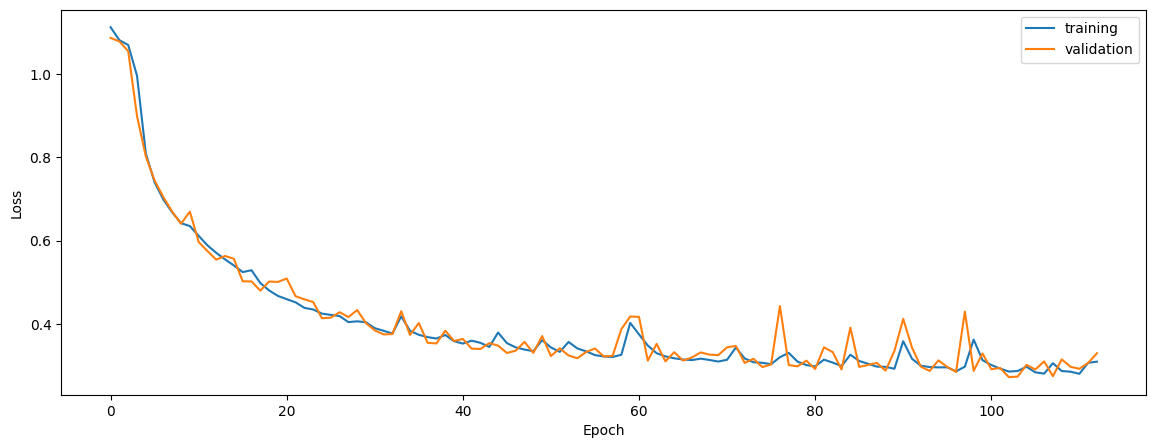

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.889010854844435


0.9007454132153797


0.877675655014247


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.9141106658446363


0.9090614996935231


0.8895934696889339


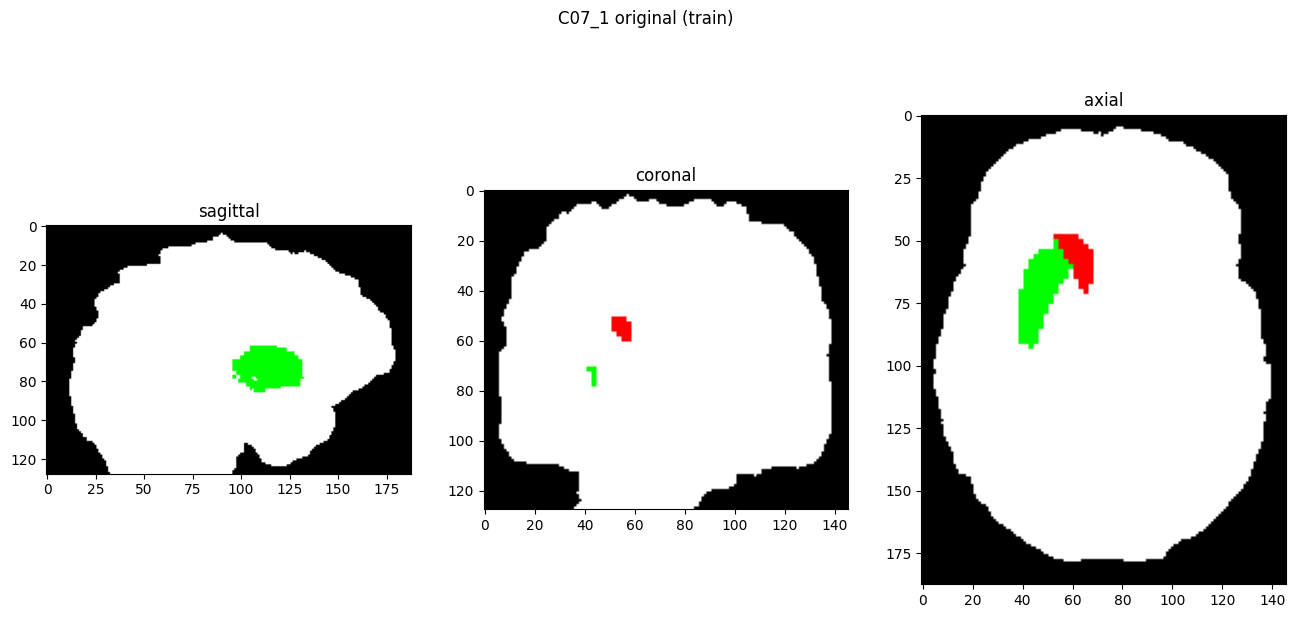

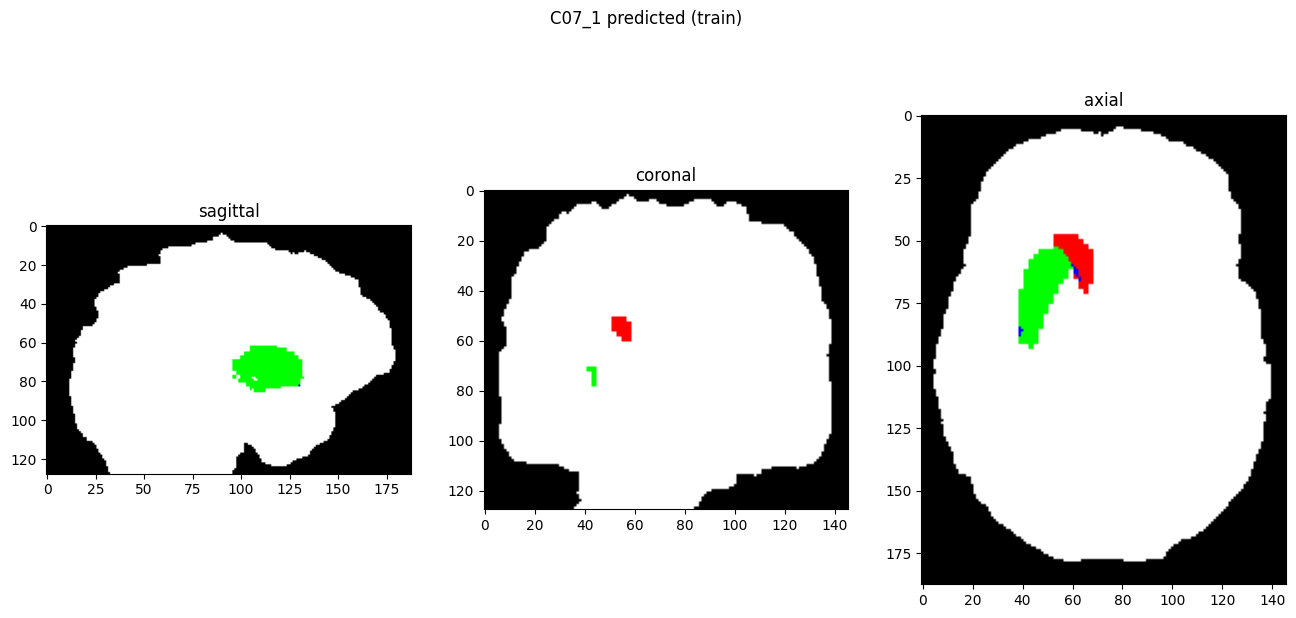

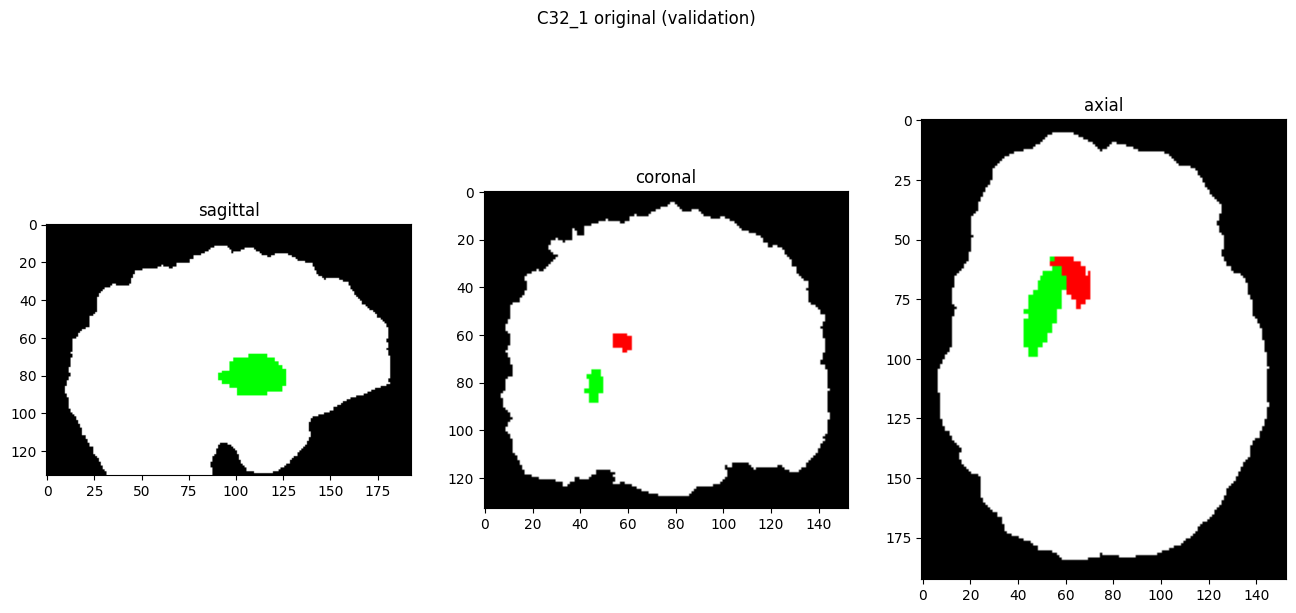

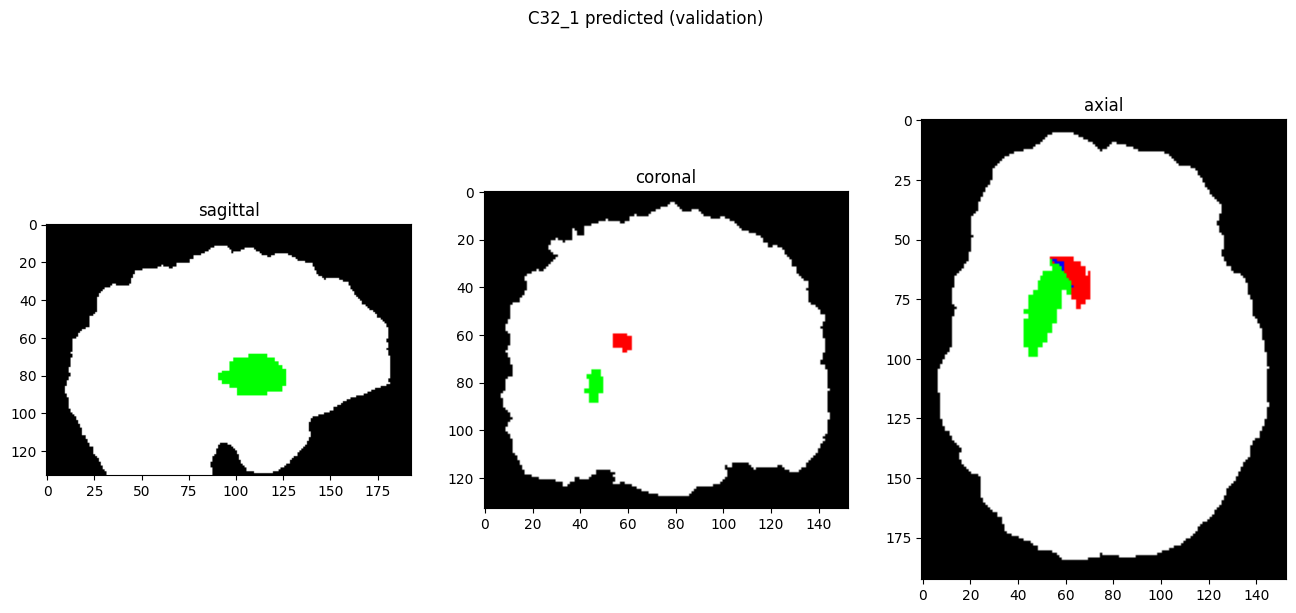

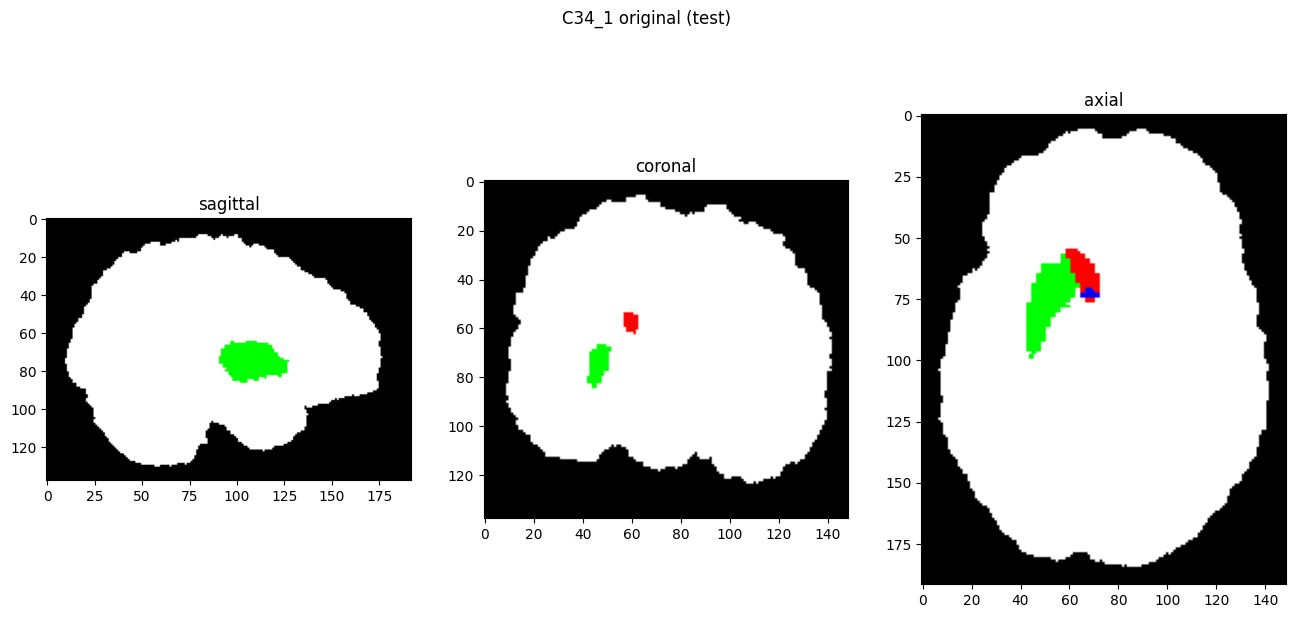

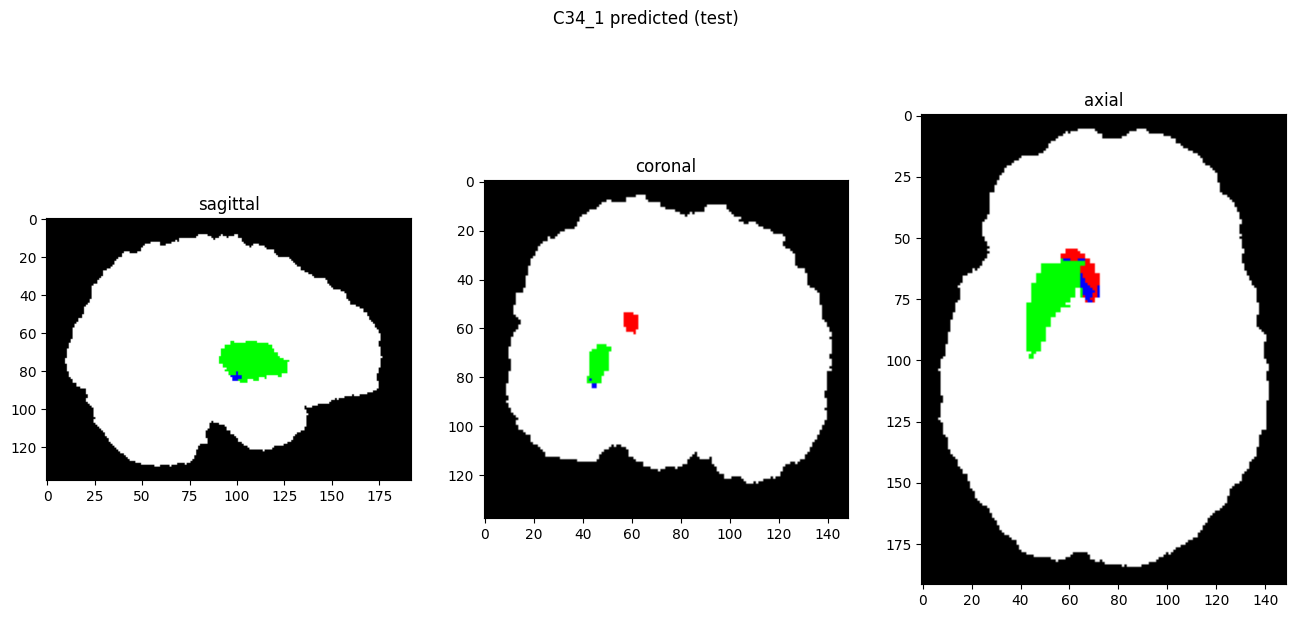

In [9]:
showResults(model, gen, threshold=0)